In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 

In [3]:
def lirinzel_ns(v2, a2, IP3, d5, k3, dt):
    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    time = np.arange(0, 100, dt)
    dt = dt
    Ca, h = [0.1], [0.1]  # Initialize lists

    # ODE solving
    for _ in range(1, len(time)):  # Start from index 1 to avoid index errors
        CaER = (c0 - Ca[-1]) / c1
        pinf = IP3 / (IP3 + d1)
        ninf = Ca[-1] / (Ca[-1] + d5)
        Q2 = d2 * (IP3 + d1) / (IP3 + d3)
        tauh = 1 / (a2 * (Q2 + Ca[-1]))
        hinf = Q2 / (Q2 + Ca[-1])
        alphah = hinf / tauh
        betah = (1 - hinf) / tauh
        dh = alphah * (1 - h[-1]) - betah * h[-1]
        dCa = (c1 * v1 * pinf**3 * ninf**3 * h[-1]**3 * (CaER - Ca[-1]) +
               c1 * v2 * (CaER - Ca[-1]) -
               v3 * Ca[-1]**2 / (Ca[-1]**2 + k3**2))

        # Append new values instead of assigning to an index
        Ca.append(Ca[-1] + dCa * dt)
        h.append(h[-1] + dh * dt)

    # Convert to NumPy array for interpolation
    Ca = np.array(Ca)
    h = np.array(h)

    return Ca, h

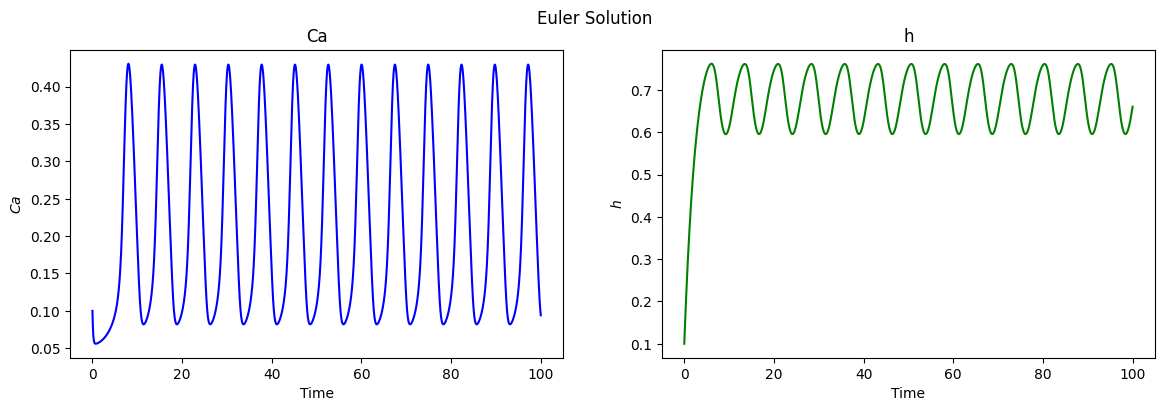

In [4]:
v2 = 0.15
a2 = 0.70
IP3 = 0.5
d5 = 0.10
k3  = 0.08

dt1 = 0.01
t1 = np.arange(0, 100, dt1)
Ca_euler1, h_euler1 = lirinzel_ns(v2, a2, IP3, d5, k3, dt1)

plt.figure(figsize=(14,4))
plt.suptitle("Euler Solution")

plt.subplot(121)
plt.plot(t1, Ca_euler1, 'b')
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca")

plt.subplot(122)
plt.plot(t1, h_euler1, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h")
plt.show()

# **Trainable Fourier Coefficients**

In [38]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        mean = 0.0
        std = 2.0
        size = (num_features, 1)
        self.sine_coeff = nn.Parameter(torch.normal(mean, std, size=size))   
        self.cosine_coeff = nn.Parameter(torch.normal(mean, std, size=size))

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features, y0):
        super().__init__()
        self.y0 = y0
        self.feature = FourierFeatureLayer(num_features=num_features)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        scaled = self.y0 + self.tanh(x) * torch.tensor([1, 1]) * out
        return scaled

Training step: 0
Loss = 0.0082930326461792 | Physics_loss = 0.5675244331359863| Initial_loss = 0.0 | Data_loss = 0.2617788016796112


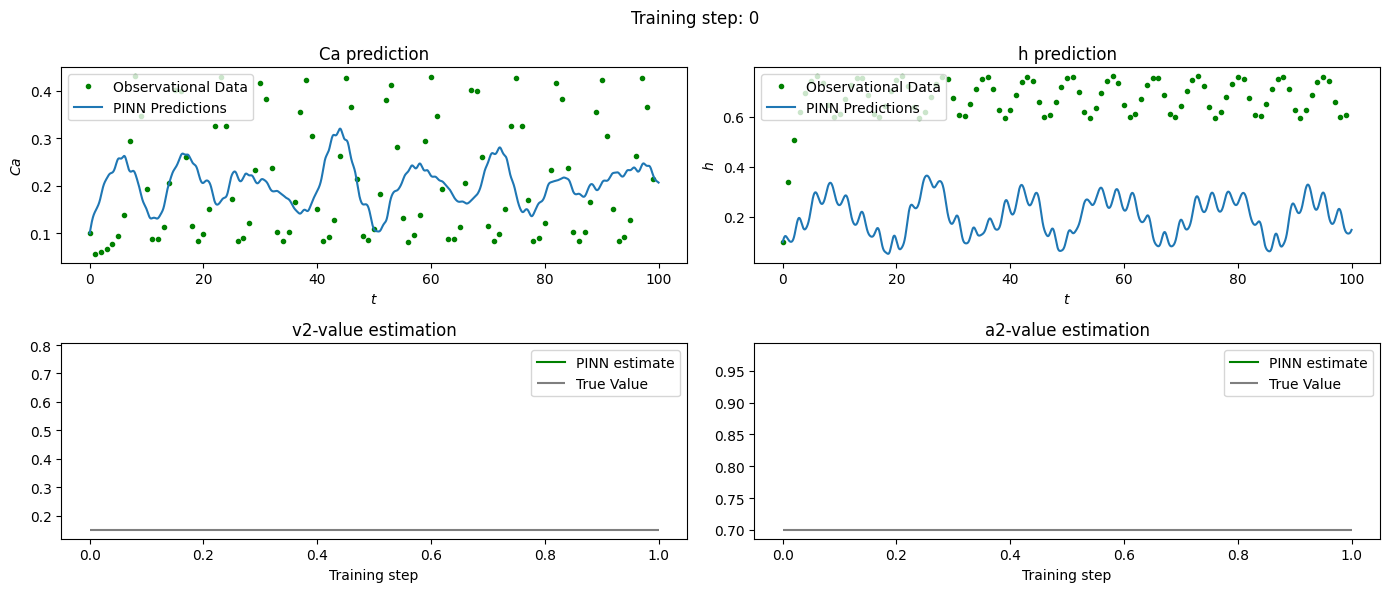

Training step: 1000
Loss = 9.818514081416652e-05 | Physics_loss = 0.003419239539653063| Initial_loss = 0.0 | Data_loss = 0.006399274803698063


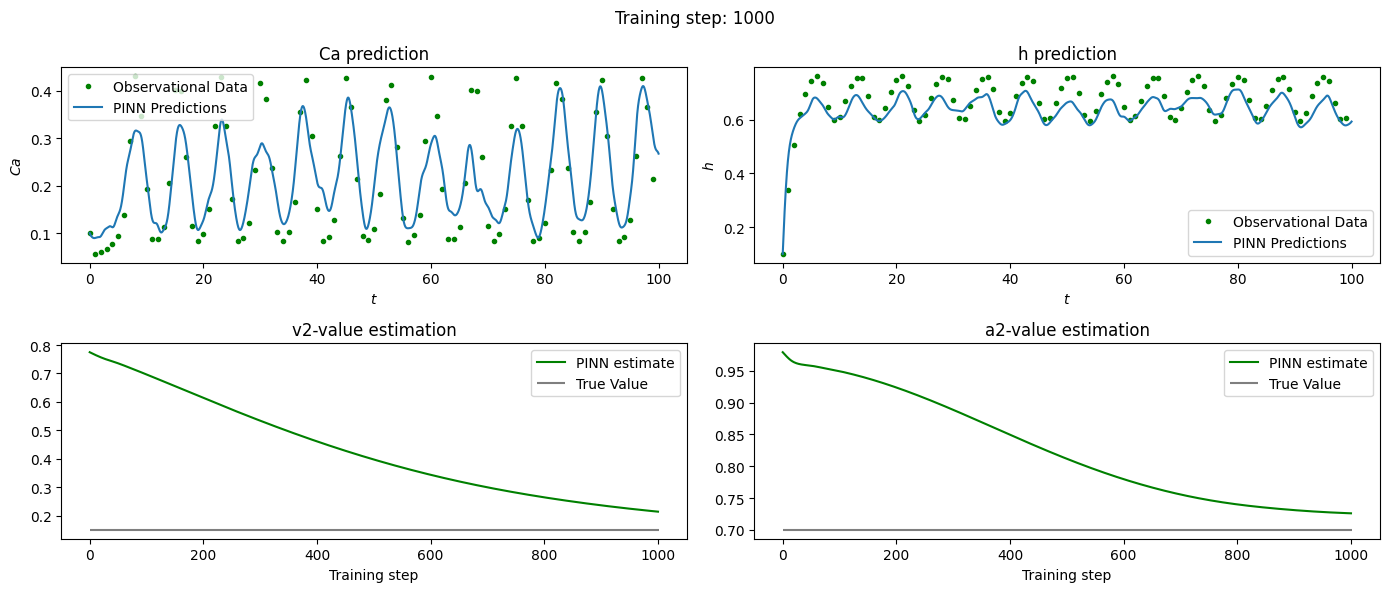

Training step: 2000
Loss = 1.0734048373706173e-05 | Physics_loss = 0.0005295250448398292| Initial_loss = 0.0 | Data_loss = 0.0005438798107206821


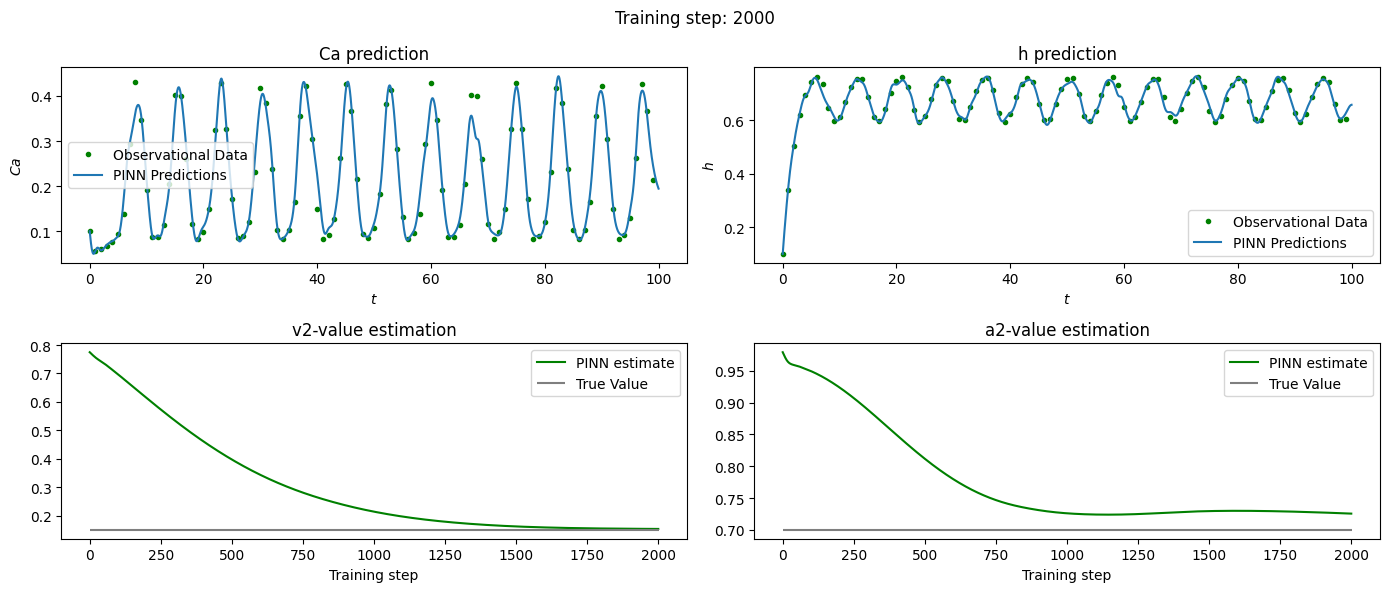

Training step: 3000
Loss = 2.477981979609467e-06 | Physics_loss = 0.00018049971549771726| Initial_loss = 0.0 | Data_loss = 6.729847518727183e-05


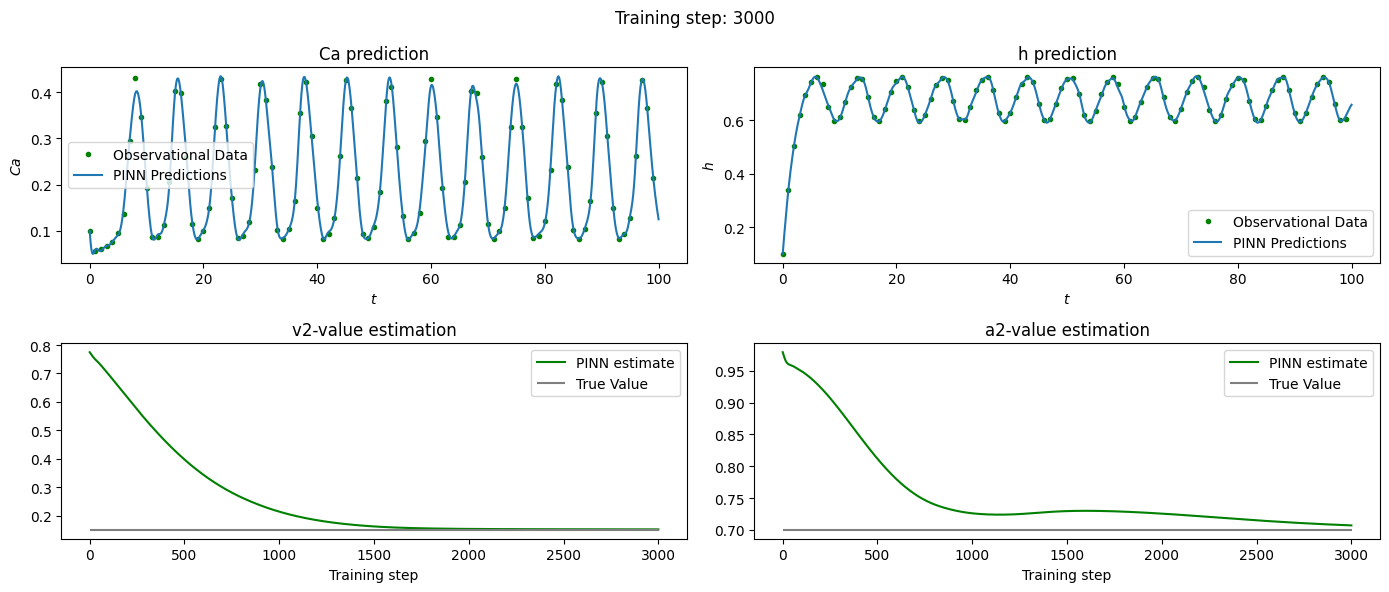

Training step: 4000
Loss = 1.1634027714535478e-06 | Physics_loss = 9.630952263250947e-05| Initial_loss = 0.0 | Data_loss = 2.0030760424560867e-05


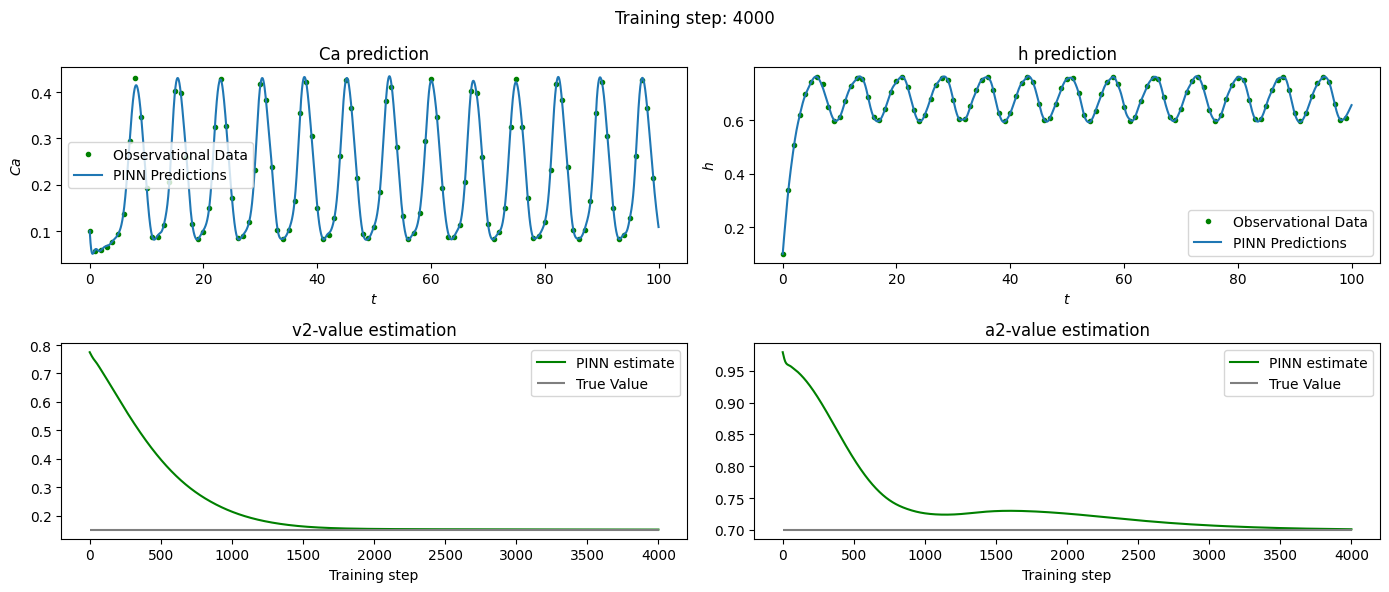

Training step: 5000
Loss = 7.876952849983354e-07 | Physics_loss = 6.744092388544232e-05| Initial_loss = 0.0 | Data_loss = 1.1328601431159768e-05


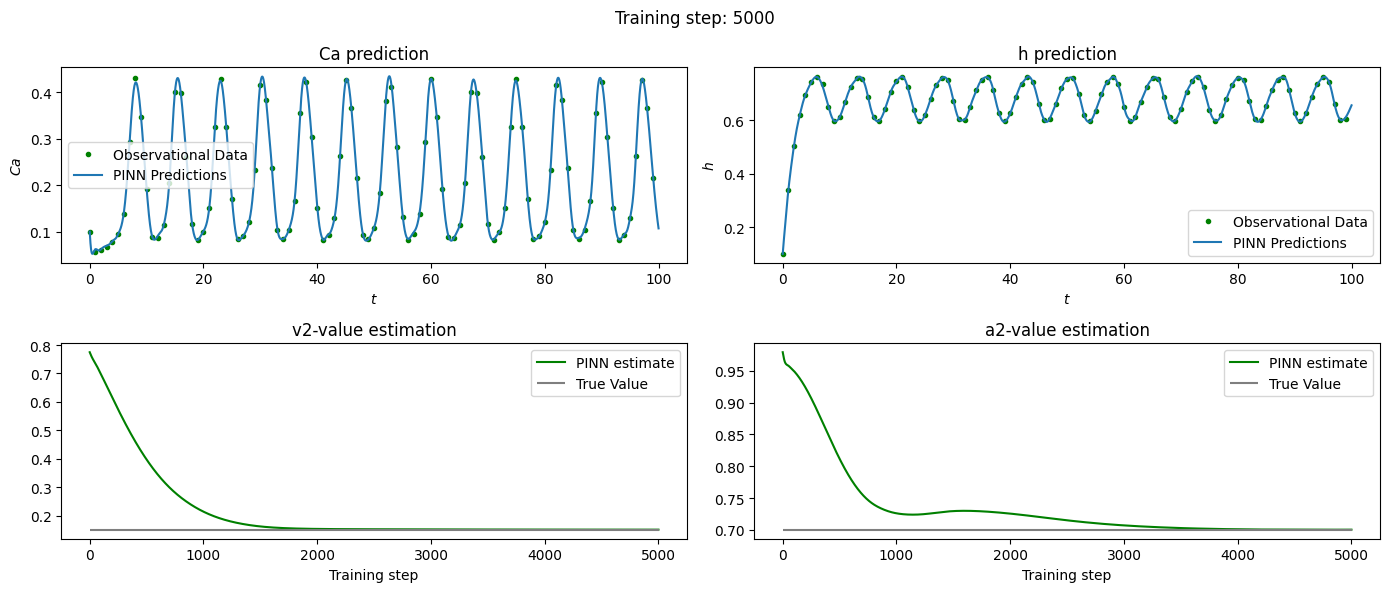

Training step: 6000
Loss = 4.3019022655244044e-07 | Physics_loss = 3.7813828384969383e-05| Initial_loss = 0.0 | Data_loss = 5.2051937018404715e-06


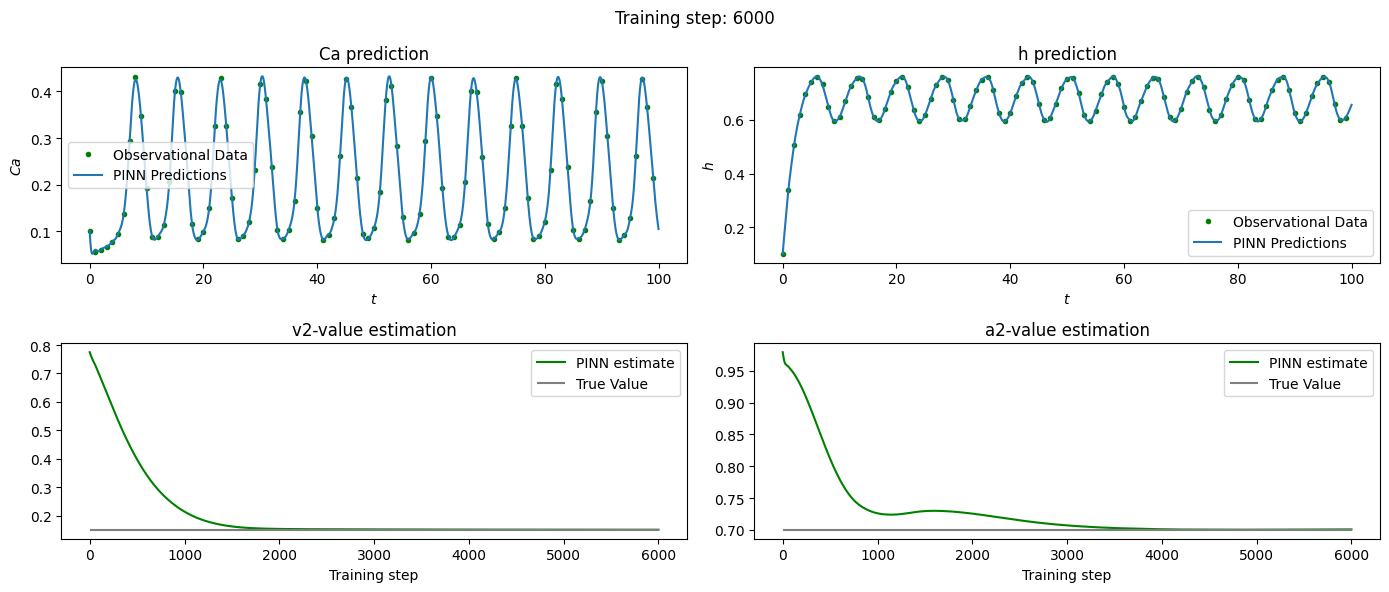

Training step: 7000
Loss = 6.982867830629402e-07 | Physics_loss = 5.934521686867811e-05| Initial_loss = 0.0 | Data_loss = 1.048346166498959e-05


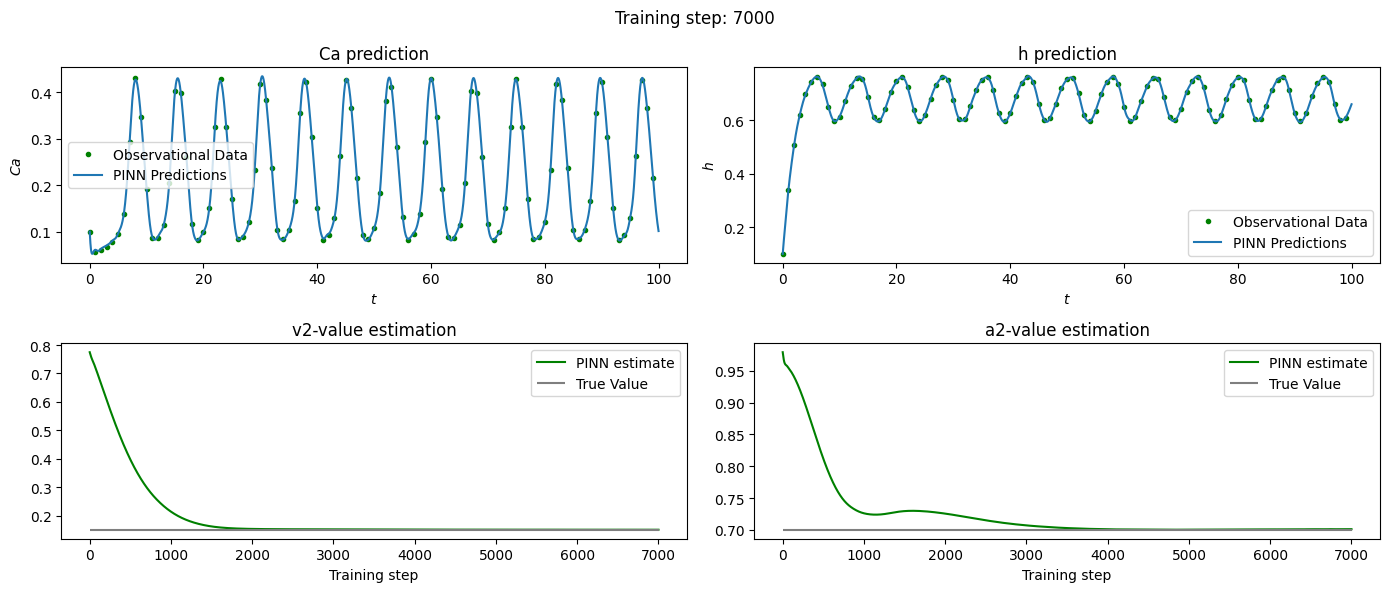

Training step: 8000
Loss = 2.824385489930137e-07 | Physics_loss = 2.5209881641785614e-05| Initial_loss = 0.0 | Data_loss = 3.0339751901919954e-06


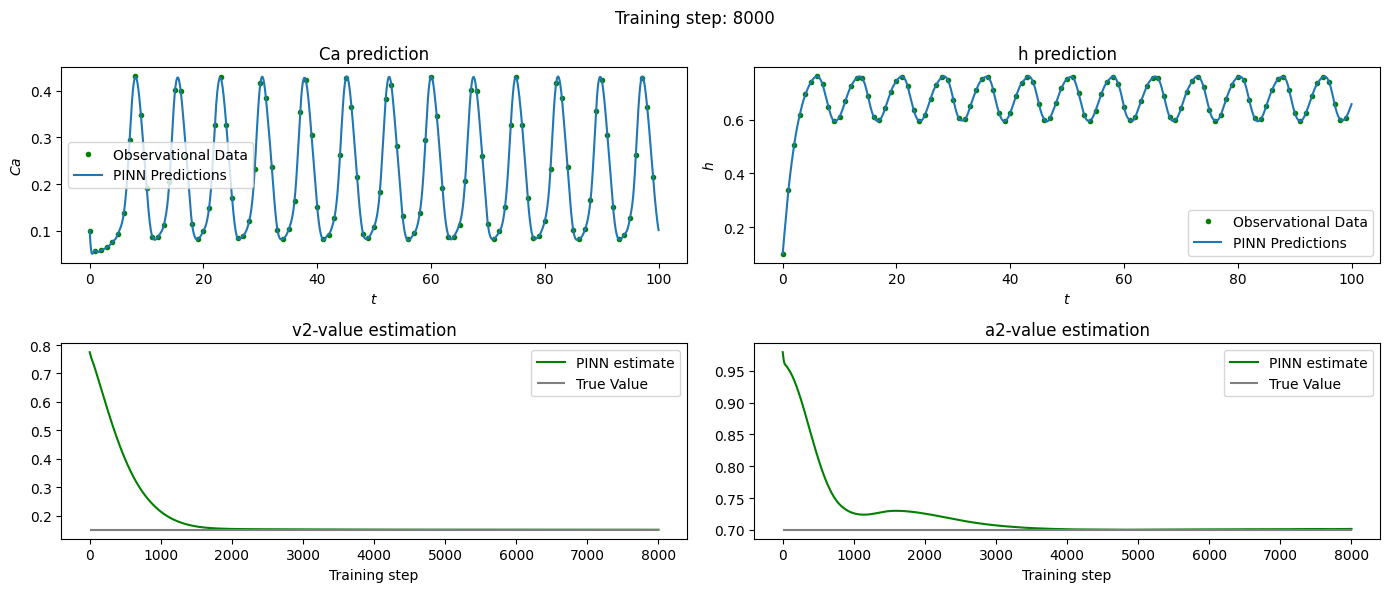

Training step: 9000
Loss = 2.385457094078447e-07 | Physics_loss = 2.1276011466397904e-05| Initial_loss = 0.0 | Data_loss = 2.5785600428207545e-06


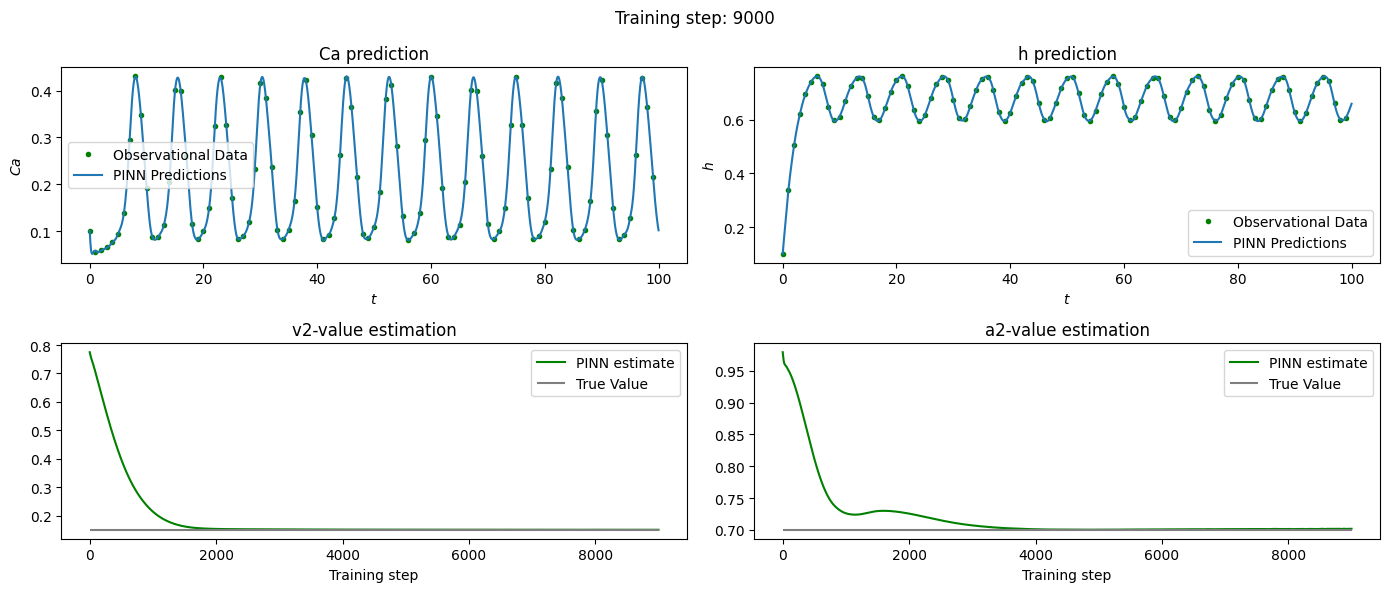

Training step: 10000
Loss = 1.0916147630268824e-06 | Physics_loss = 9.331047476734966e-05| Initial_loss = 0.0 | Data_loss = 1.585100108059123e-05


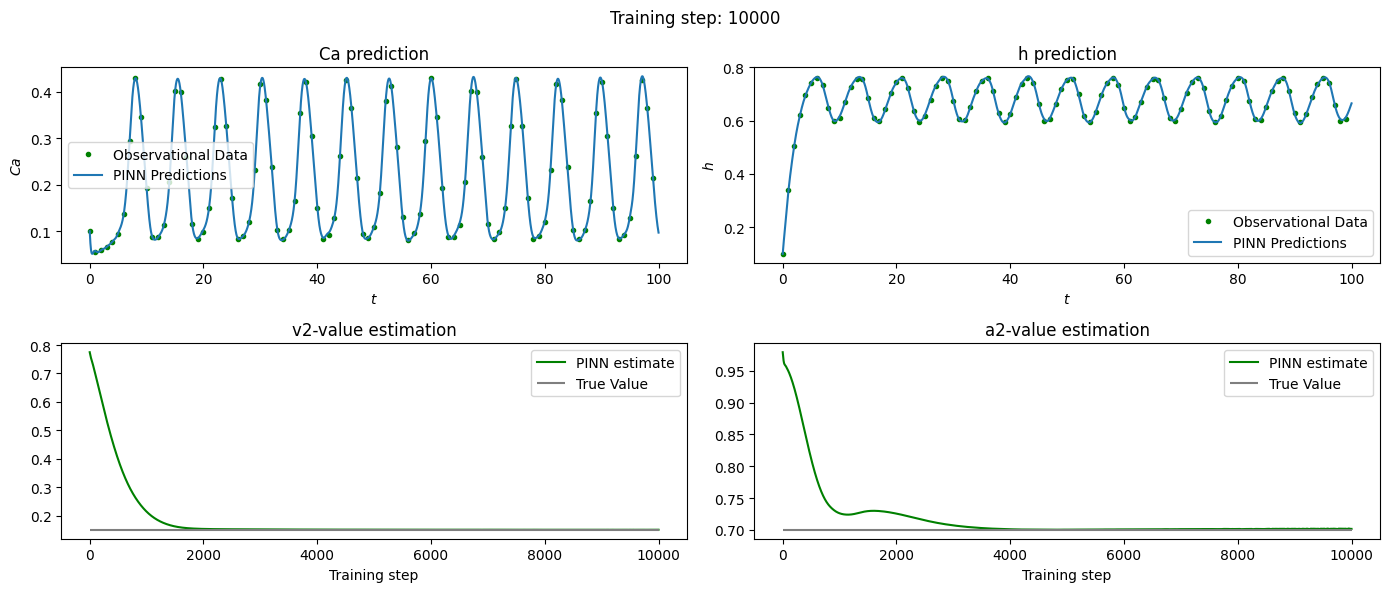

In [ ]:
torch.manual_seed(42)
pinn = PinnModel(hidden_units=30, num_features=3, y0=torch.tensor([0.1, 0.1]).view(1,-1))

Ca_euler = torch.tensor(Ca_euler1, dtype=torch.float32)[::100]
h_euler = torch.tensor(h_euler1, dtype=torch.float32)[::100]
t_test = torch.arange(0, 100, 0.01).view(-1, 1)
time = torch.arange(0, 100, 1.0).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, 100, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.10
k3  = 0.08
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.1
#a2 = 0.15

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  10001
v2s = []
a2s = []
sine_coeffs = []
cosine_coeffs = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - 0.1)**2
    loss4 = (torch.squeeze(h0) - 0.1)**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 100 == 0:
      sine_coeffs.append(pinn.feature.sine_coeff.detach().cpu().numpy().copy())
      cosine_coeffs.append(pinn.feature.cosine_coeff.detach().cpu().numpy().copy())

    if i % 1000 == 0:
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss5 + loss6}| Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(222)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()

        plt.subplot(223)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(0.15, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")

        plt.subplot(224)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(0.70, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()


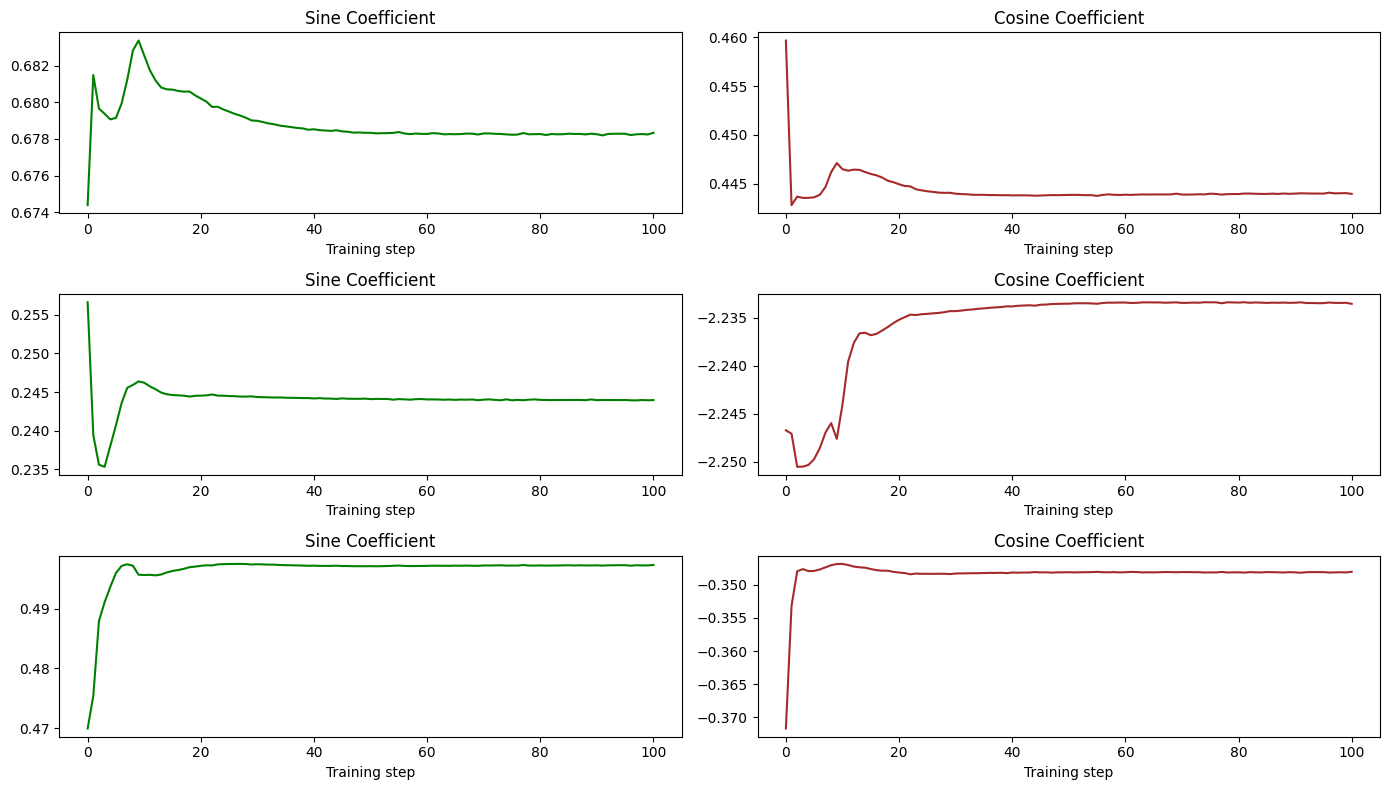

In [62]:
sine_coeffs = np.array(sine_coeffs)
cosine_coeffs = np.array(cosine_coeffs)

plt.figure(figsize=(14,8))

for i in range(3):
    plt.subplot(3, 2, 2*i+1)
    plt.plot(sine_coeffs[:, i], c="green")
    plt.title("Sine Coefficient")
    plt.xlabel("Training step")

for i in range(3):
    plt.subplot(3, 2, 2*(i+1))
    plt.plot(cosine_coeffs[:, i], c="brown")
    plt.title("Cosine Coefficient")
    plt.xlabel("Training step")

plt.tight_layout()
plt.show()

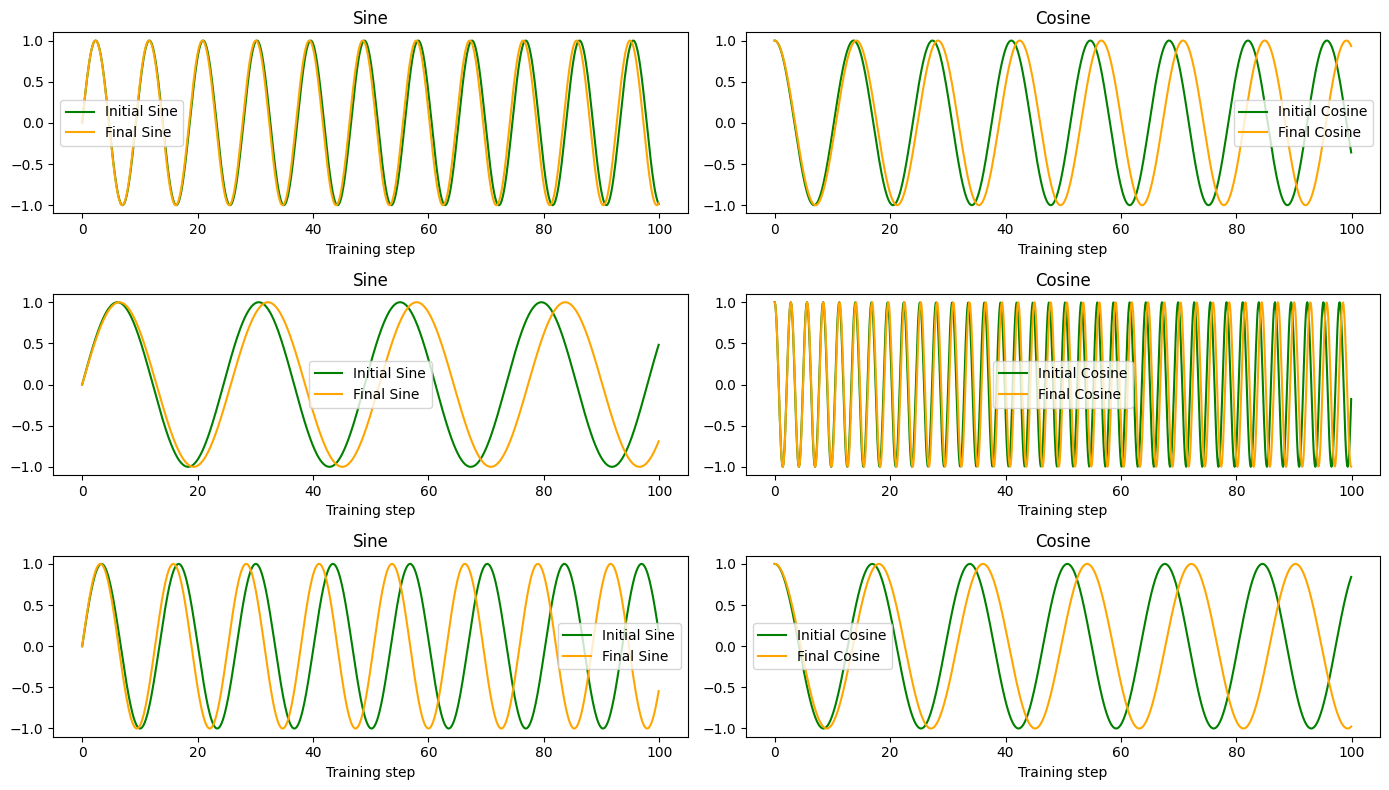

In [65]:
x = np.arange(0, 100, 0.1)

plt.figure(figsize=(14,8))

for i in range(3):
    plt.subplot(3, 2, 2*i+1)
    plt.plot(x, np.sin(sine_coeffs[0, i] * x), c="green", label="Initial Sine")
    plt.plot(x, np.sin(sine_coeffs[-1, i] * x), c="orange", label="Final Sine")
    plt.title("Sine")
    plt.xlabel("Training step")
    plt.legend()

for i in range(3):
    plt.subplot(3, 2, 2*(i+1))
    plt.plot(x, np.cos(cosine_coeffs[0, i] * x), c="green", label="Initial Cosine")
    plt.plot(x, np.cos(cosine_coeffs[-1, i] * x), c="orange", label="Final Cosine")
    plt.title("Cosine")
    plt.xlabel("Training step")
    plt.legend()

plt.tight_layout()
plt.show()

# **Non Trainable Fourier Coefficients**

In [5]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        mean = 0.0
        std = 2.0
        size = (num_features, 1)
        self.sine_coeff = torch.normal(mean, std, size=size)   
        self.cosine_coeff = torch.normal(mean, std, size=size)

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features, y0):
        super().__init__()
        self.y0 = y0
        self.feature = FourierFeatureLayer(num_features=num_features)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        scaled = self.y0 + self.tanh(x) * torch.tensor([1, 1]) * out
        return scaled

Training step: 0
Loss = 0.0082930326461792 | Physics_loss = 0.5675244331359863| Initial_loss = 0.0 | Data_loss = 0.2617788016796112


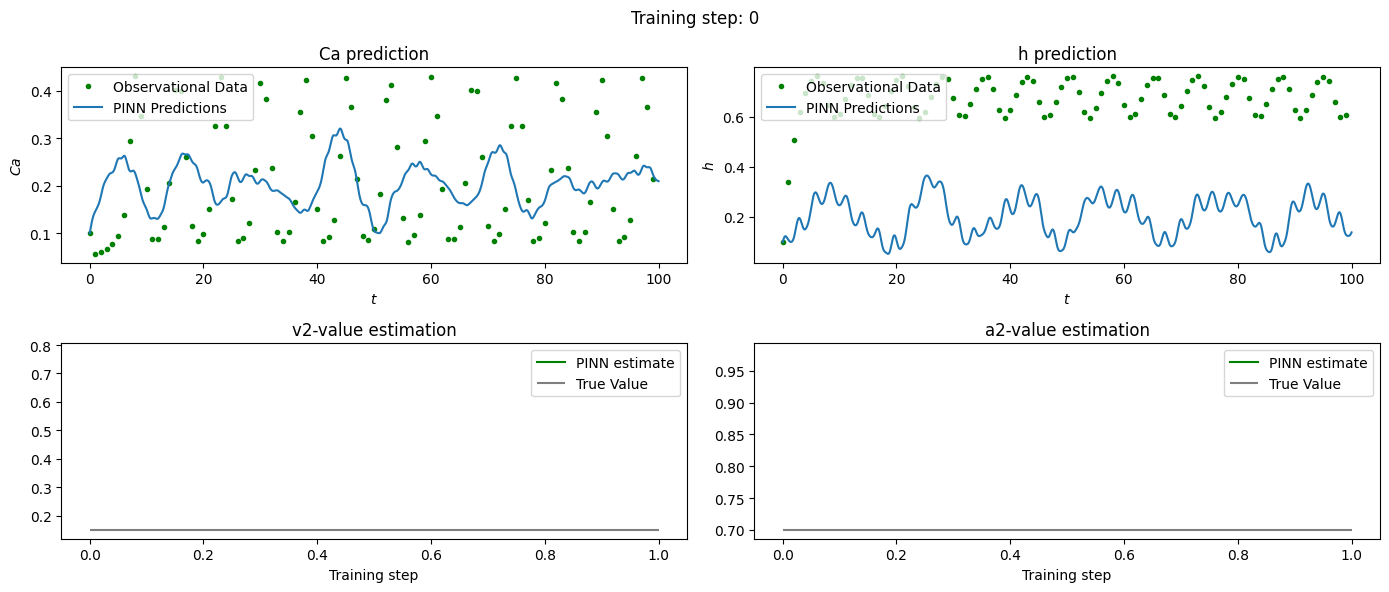

Training step: 1000
Loss = 0.00013855978613719344 | Physics_loss = 0.0037398773711174726| Initial_loss = 0.0 | Data_loss = 0.010116102173924446


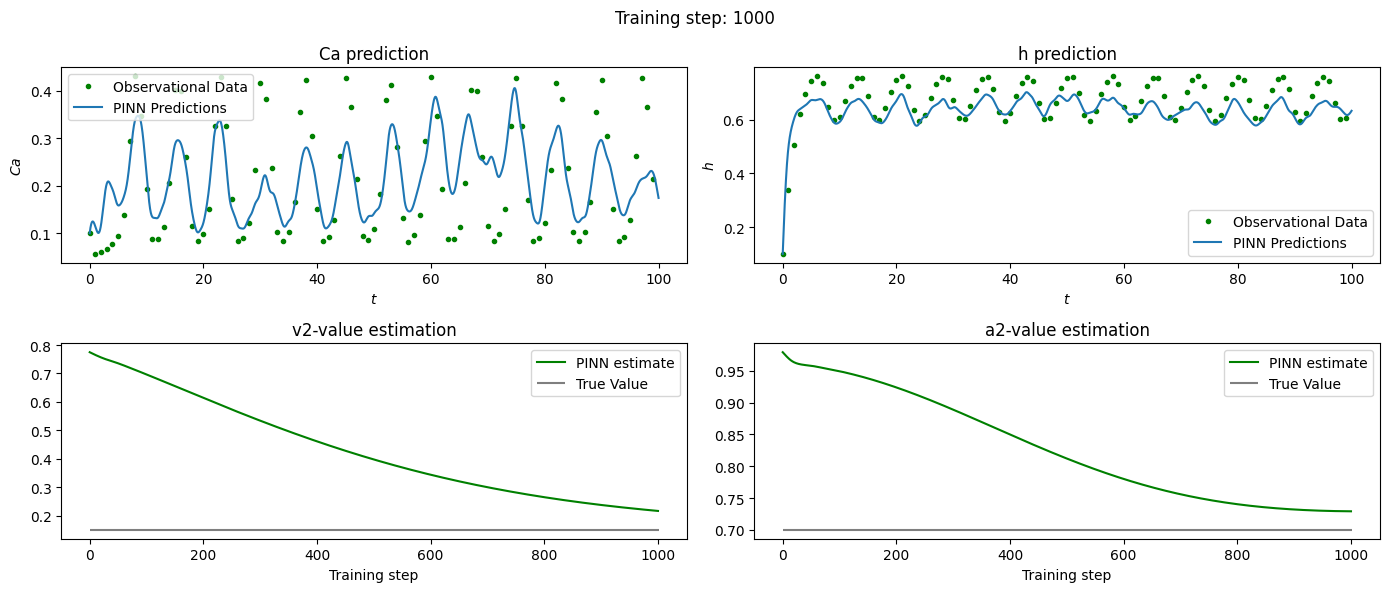

Training step: 2000
Loss = 2.751467218331527e-05 | Physics_loss = 0.0013060875935479999| Initial_loss = 0.0 | Data_loss = 0.0014453796902671456


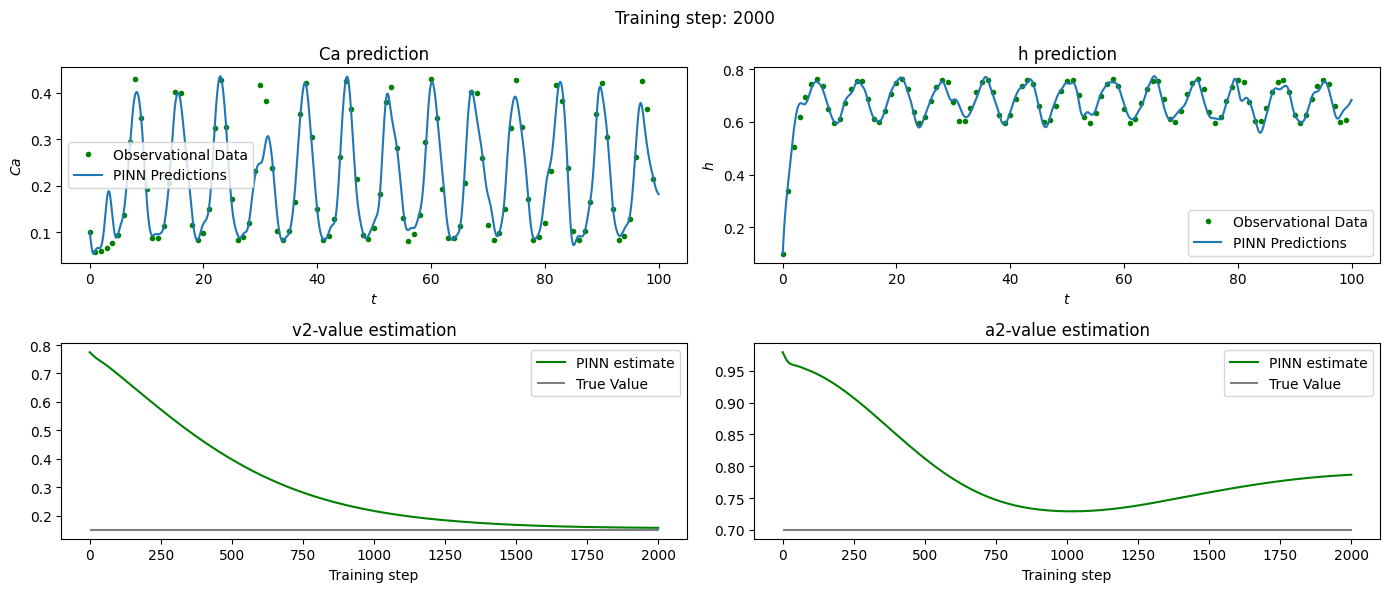

Training step: 3000
Loss = 9.991879778681323e-06 | Physics_loss = 0.000575853162445128| Initial_loss = 0.0 | Data_loss = 0.00042333482997491956


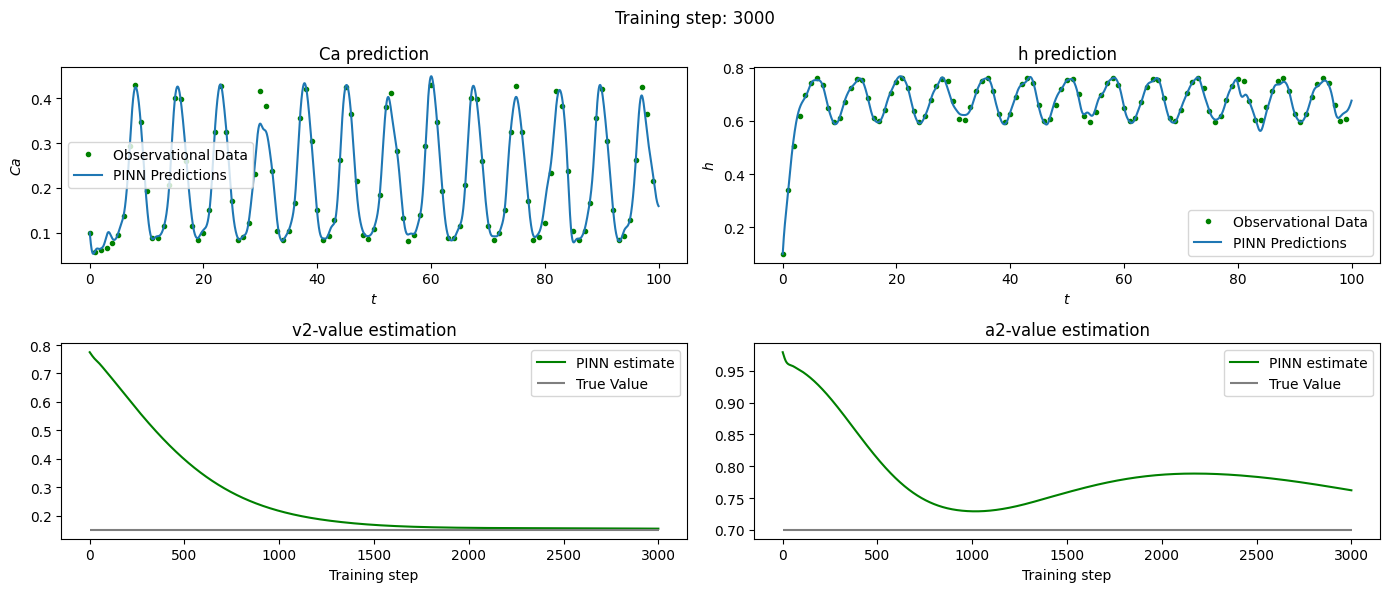

Training step: 4000
Loss = 4.605618869391037e-06 | Physics_loss = 0.0003242527600377798| Initial_loss = 0.0 | Data_loss = 0.00013630914327222854


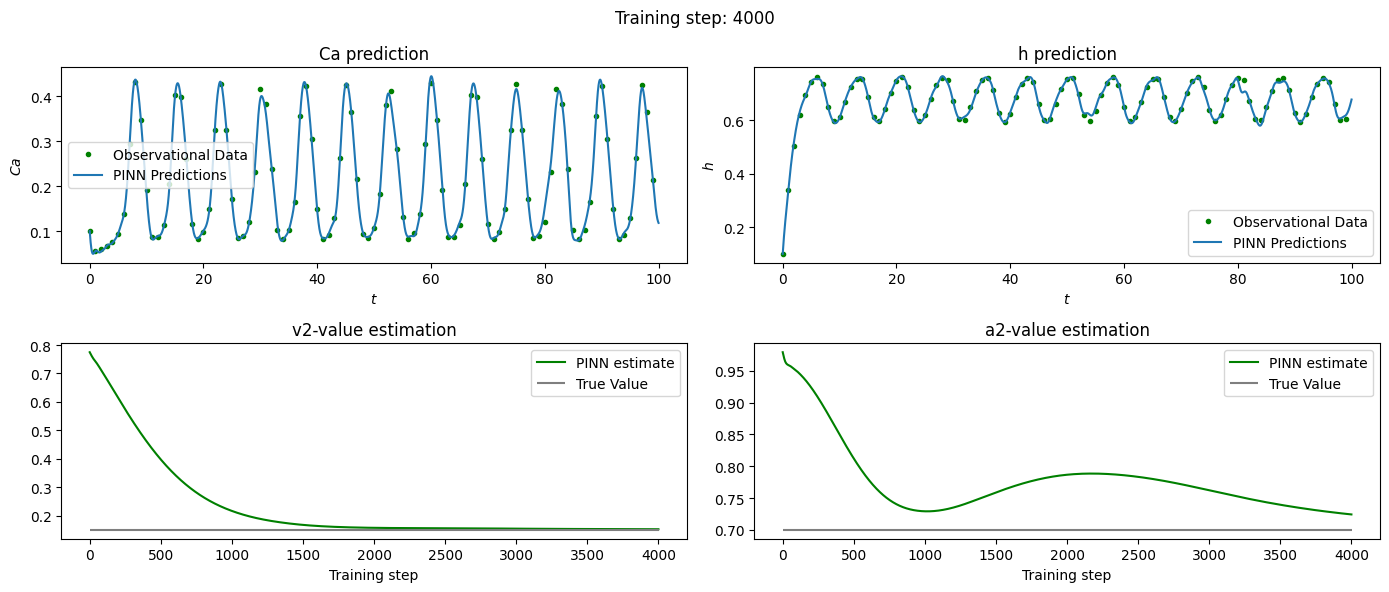

Training step: 5000
Loss = 3.0235189569793874e-06 | Physics_loss = 0.00023382666404359043| Initial_loss = 0.0 | Data_loss = 6.852523802081123e-05


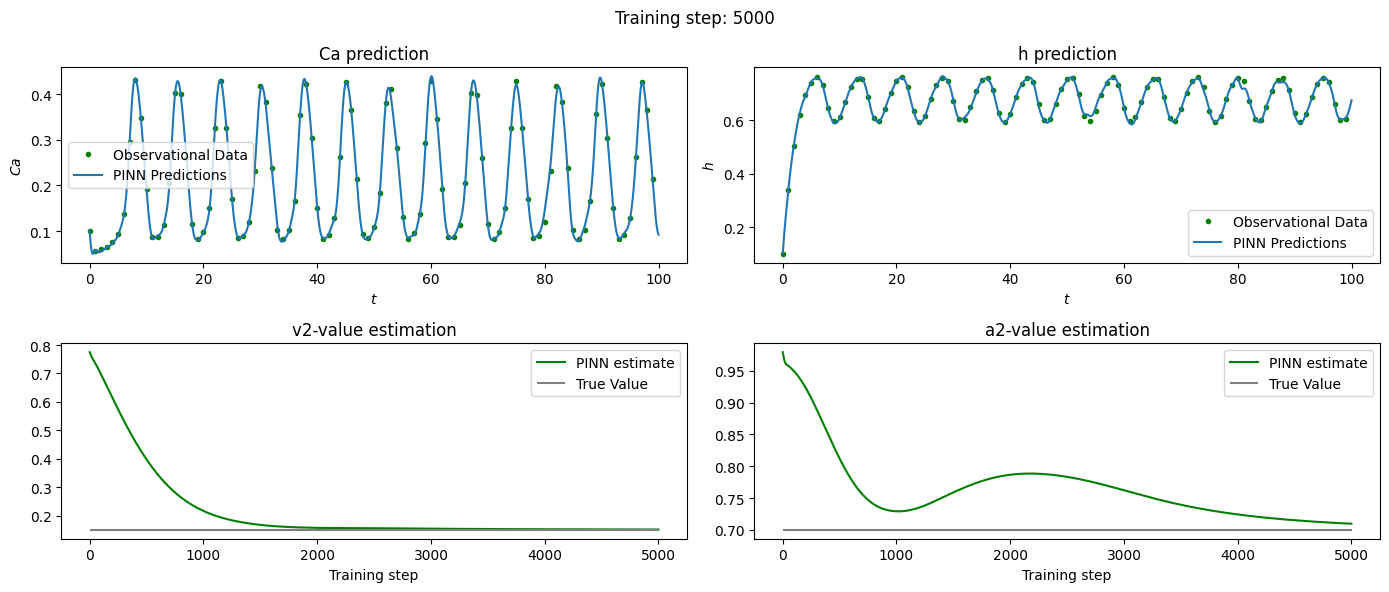

Training step: 6000
Loss = 1.7761674371286063e-06 | Physics_loss = 0.00013748655328527093| Initial_loss = 0.0 | Data_loss = 4.013018769910559e-05


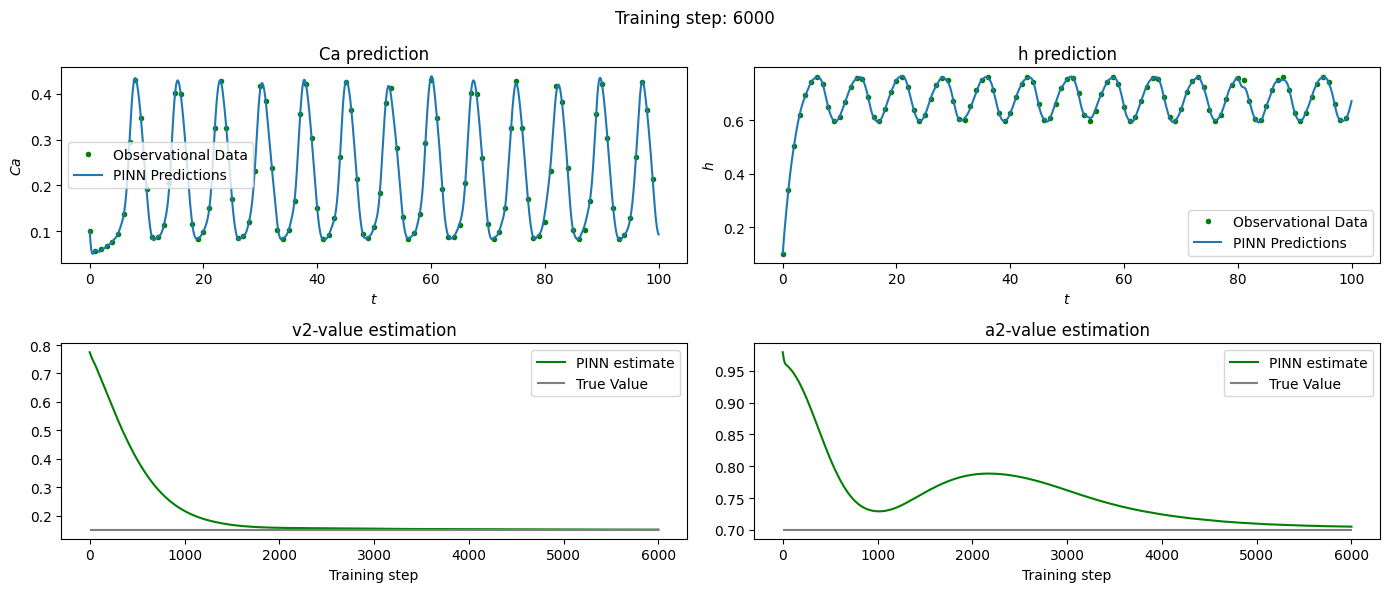

Training step: 7000
Loss = 2.2197270936885616e-06 | Physics_loss = 0.00018519384320825338| Initial_loss = 0.0 | Data_loss = 3.677887070807628e-05


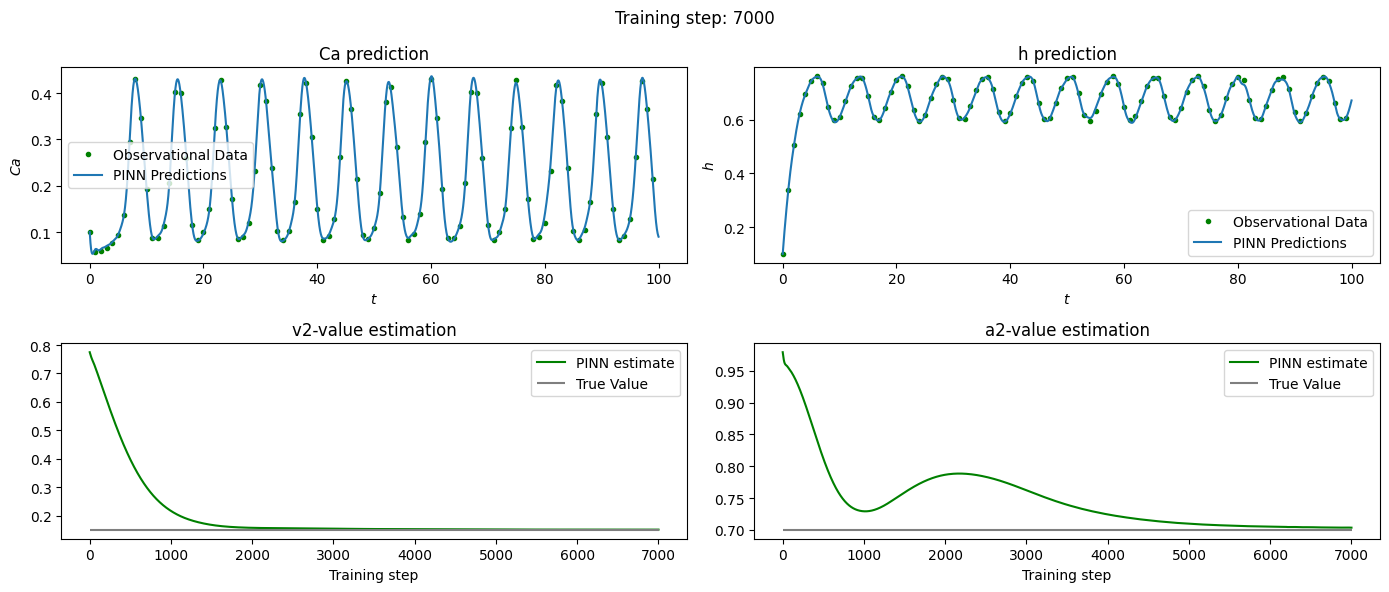

Training step: 8000
Loss = 1.3329290595720522e-06 | Physics_loss = 0.00010947154078166932| Initial_loss = 0.0 | Data_loss = 2.3821366994525306e-05


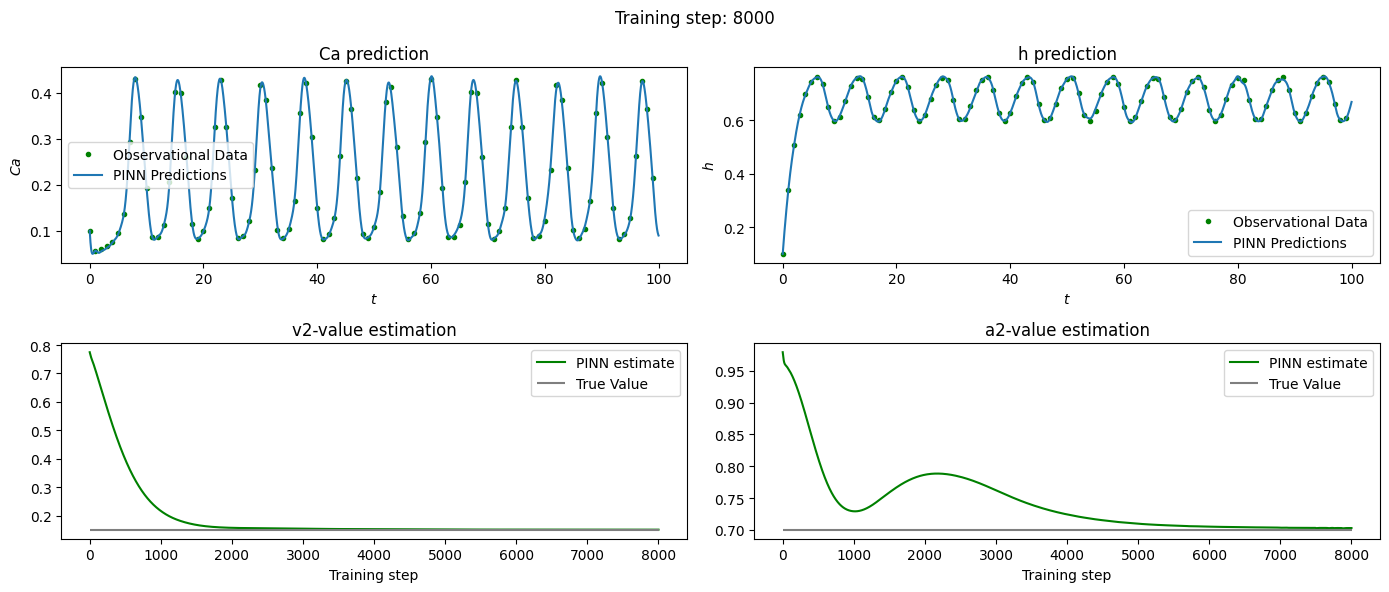

Training step: 9000
Loss = 8.517828860021837e-07 | Physics_loss = 7.181403634604067e-05| Initial_loss = 0.0 | Data_loss = 1.3364252481551375e-05


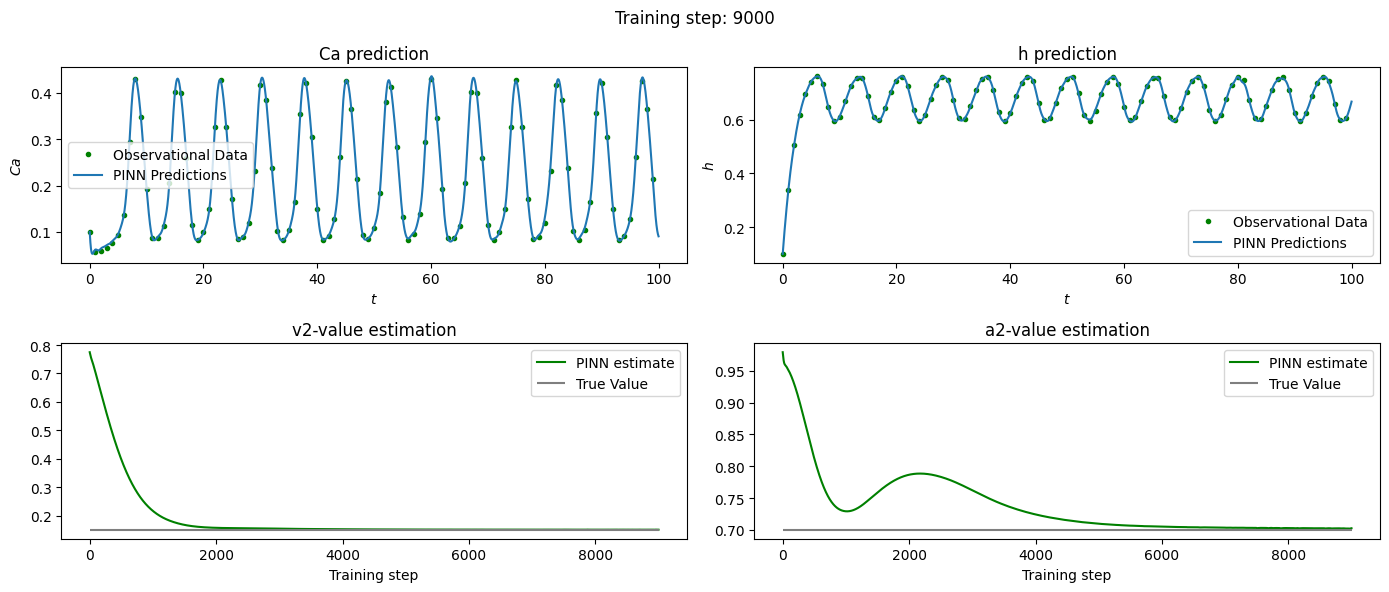

Training step: 10000
Loss = 5.51835569240211e-07 | Physics_loss = 4.6858840505592525e-05| Initial_loss = 0.0 | Data_loss = 8.324721420649439e-06


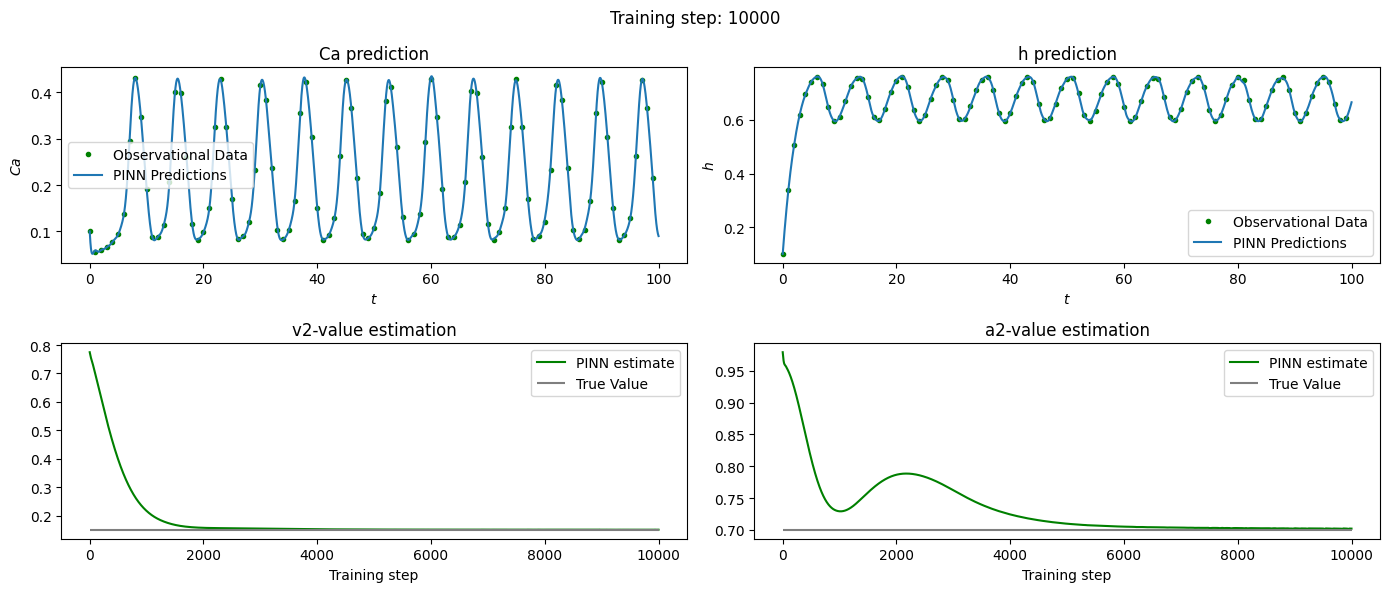

In [6]:
torch.manual_seed(42)
pinn = PinnModel(hidden_units=30, num_features=3, y0=torch.tensor([0.1, 0.1]).view(1,-1))

Ca_euler = torch.tensor(Ca_euler1, dtype=torch.float32)[::100]
h_euler = torch.tensor(h_euler1, dtype=torch.float32)[::100]
t_test = torch.arange(0, 100, 0.01).view(-1, 1)
time = torch.arange(0, 100, 1.0).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, 100, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.10
k3  = 0.08
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.1
#a2 = 0.15

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  10001
v2s = []
a2s = []
sine_coeffs = []
cosine_coeffs = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - 0.1)**2
    loss4 = (torch.squeeze(h0) - 0.1)**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 100 == 0:
      sine_coeffs.append(pinn.feature.sine_coeff.detach().cpu().numpy().copy())
      cosine_coeffs.append(pinn.feature.cosine_coeff.detach().cpu().numpy().copy())

    if i % 1000 == 0:
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss5 + loss6}| Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(222)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()

        plt.subplot(223)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(0.15, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")

        plt.subplot(224)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(0.70, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()


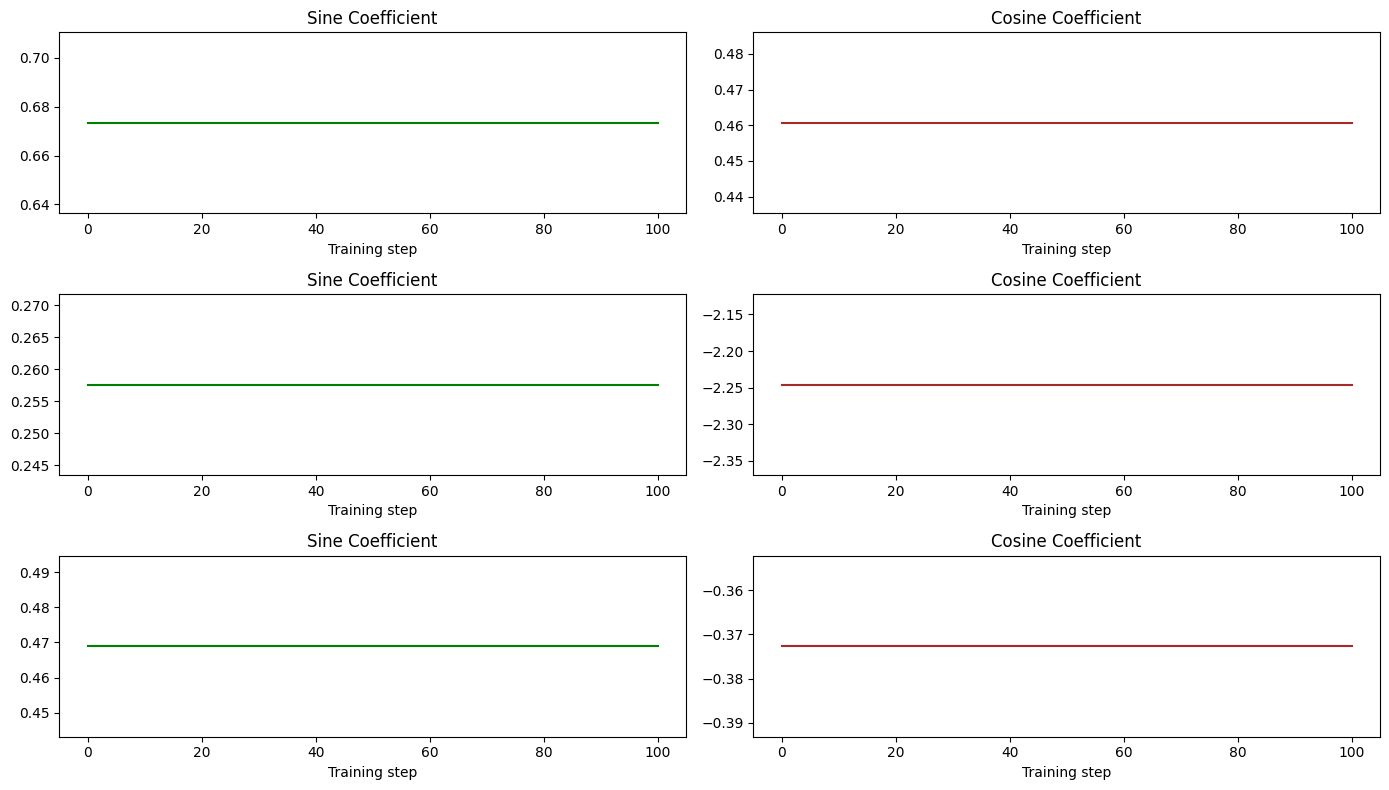

In [7]:
sine_coeffs = np.array(sine_coeffs)
cosine_coeffs = np.array(cosine_coeffs)

plt.figure(figsize=(14,8))

for i in range(3):
    plt.subplot(3, 2, 2*i+1)
    plt.plot(sine_coeffs[:, i], c="green")
    plt.title("Sine Coefficient")
    plt.xlabel("Training step")

for i in range(3):
    plt.subplot(3, 2, 2*(i+1))
    plt.plot(cosine_coeffs[:, i], c="brown")
    plt.title("Cosine Coefficient")
    plt.xlabel("Training step")

plt.tight_layout()
plt.show()

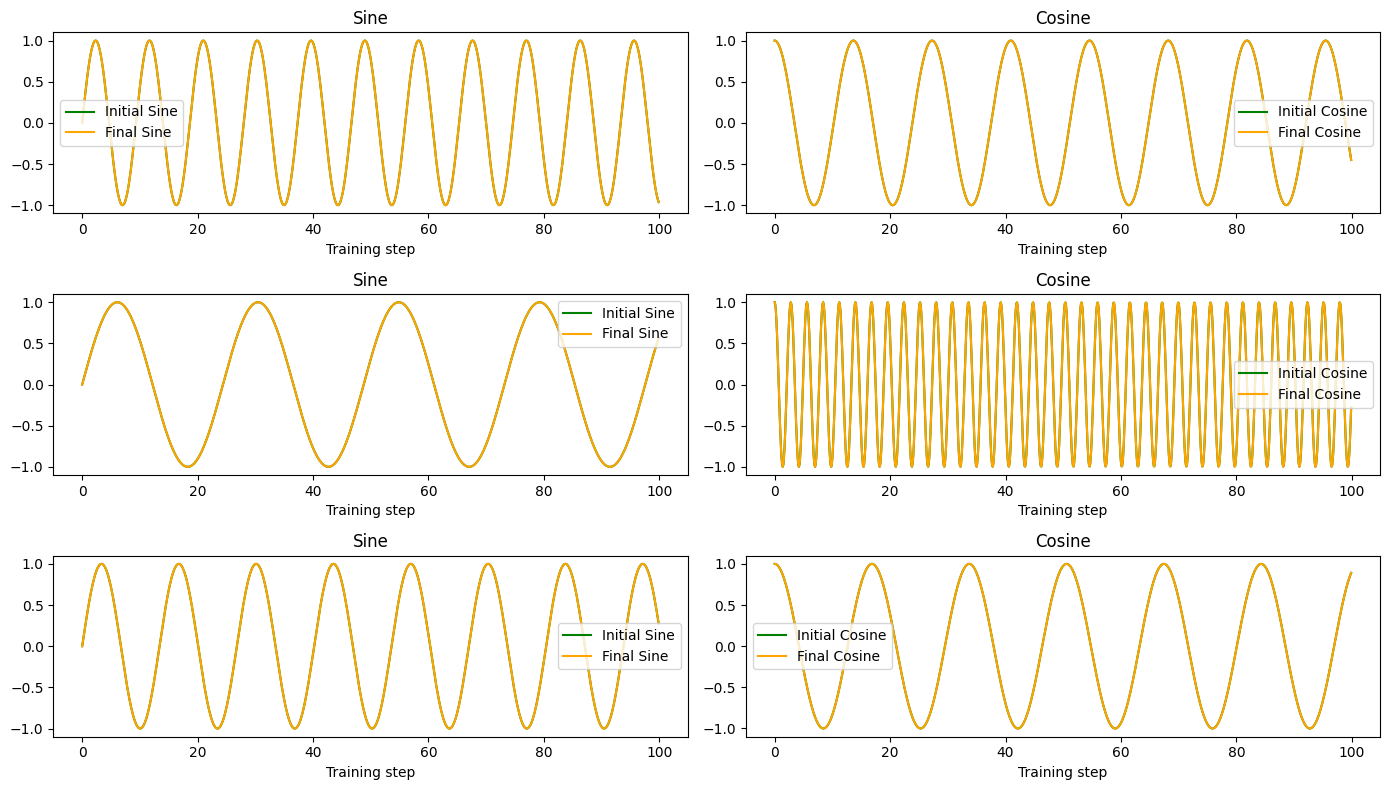

In [8]:
x = np.arange(0, 100, 0.1)

plt.figure(figsize=(14,8))

for i in range(3):
    plt.subplot(3, 2, 2*i+1)
    plt.plot(x, np.sin(sine_coeffs[0, i] * x), c="green", label="Initial Sine")
    plt.plot(x, np.sin(sine_coeffs[-1, i] * x), c="orange", label="Final Sine")
    plt.title("Sine")
    plt.xlabel("Training step")
    plt.legend()

for i in range(3):
    plt.subplot(3, 2, 2*(i+1))
    plt.plot(x, np.cos(cosine_coeffs[0, i] * x), c="green", label="Initial Cosine")
    plt.plot(x, np.cos(cosine_coeffs[-1, i] * x), c="orange", label="Final Cosine")
    plt.title("Cosine")
    plt.xlabel("Training step")
    plt.legend()

plt.tight_layout()
plt.show()

# **Without Fourier Features**

In [9]:
class PinnModel(nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.layer1 = nn.Linear(in_features=1, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(x)))))))
        return out

Training step: 1
Loss = 0.07519573718309402 | Physics_loss = 0.902716875076294| Initial_loss = 0.05993877351284027 | Data_loss = 0.6229795813560486


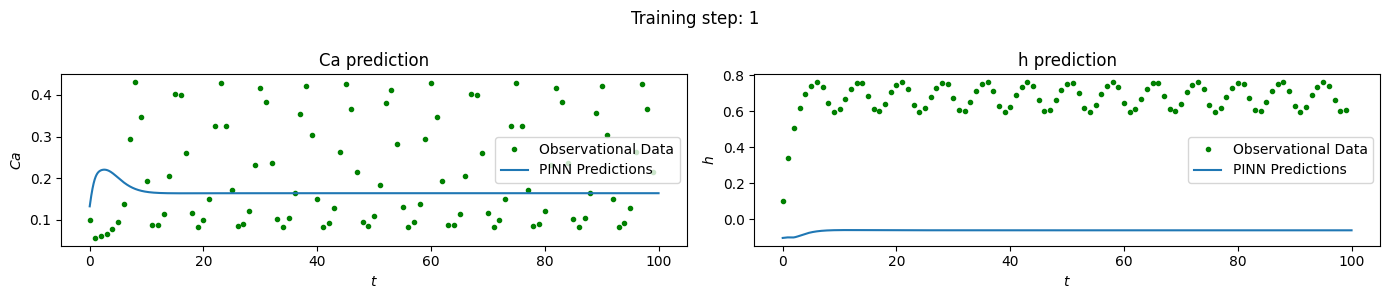

Training step: 2
Loss = 0.05591157078742981 | Physics_loss = 0.7490843534469604| Initial_loss = 0.042760271579027176 | Data_loss = 0.5660455822944641


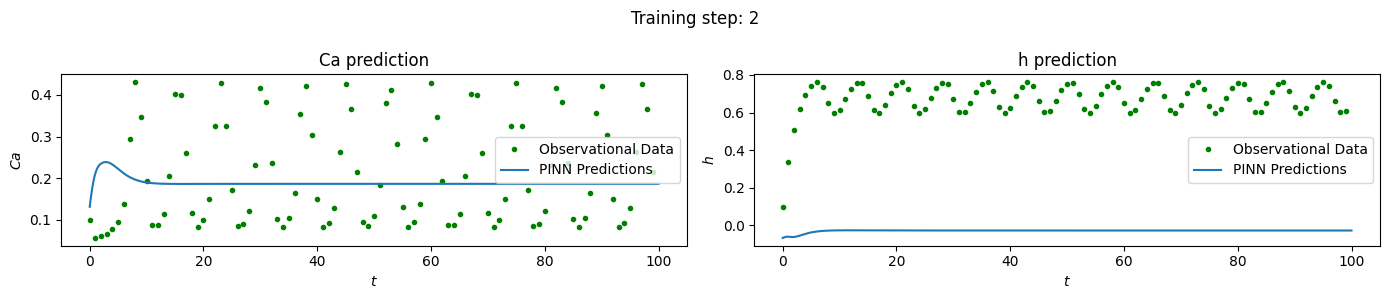

Training step: 3
Loss = 0.040372610092163086 | Physics_loss = 0.6534408330917358| Initial_loss = 0.028696231544017792 | Data_loss = 0.514197051525116


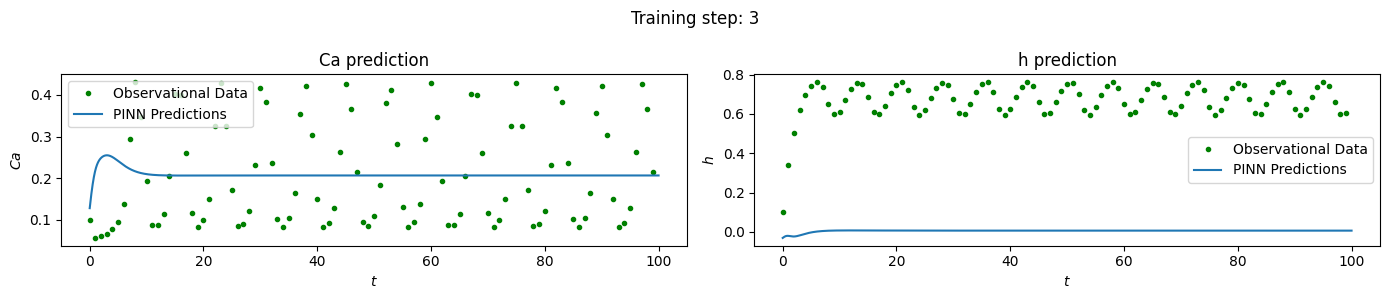

Training step: 4
Loss = 0.02821614407002926 | Physics_loss = 0.5809304118156433| Initial_loss = 0.017737027257680893 | Data_loss = 0.46698135137557983


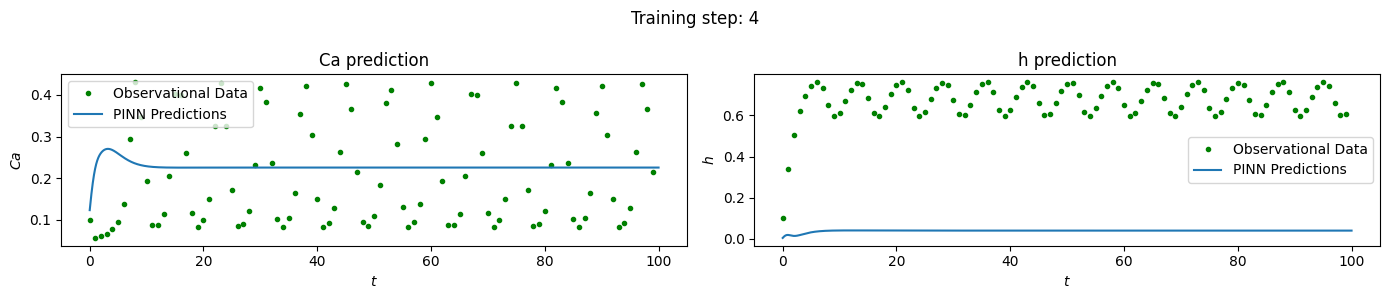

Training step: 5
Loss = 0.019142018631100655 | Physics_loss = 0.5212101936340332| Initial_loss = 0.00968955922871828 | Data_loss = 0.4240357279777527


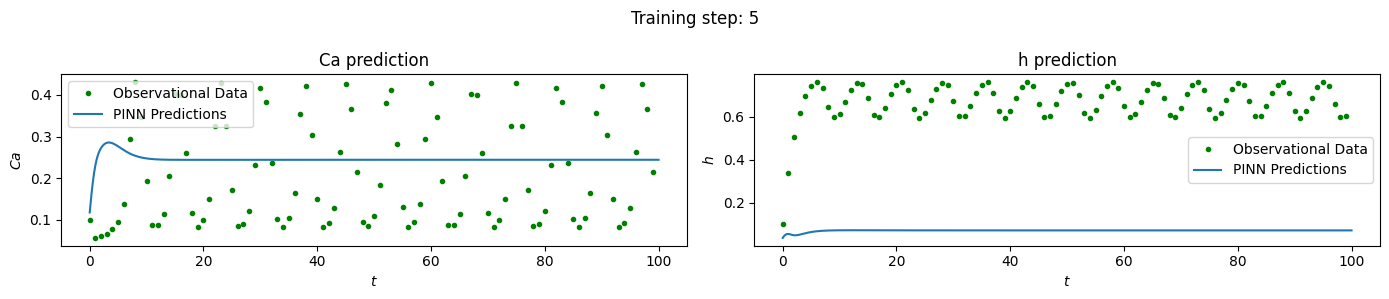

Training step: 6
Loss = 0.012837909162044525 | Physics_loss = 0.4696783423423767| Initial_loss = 0.004288849420845509 | Data_loss = 0.3852277398109436


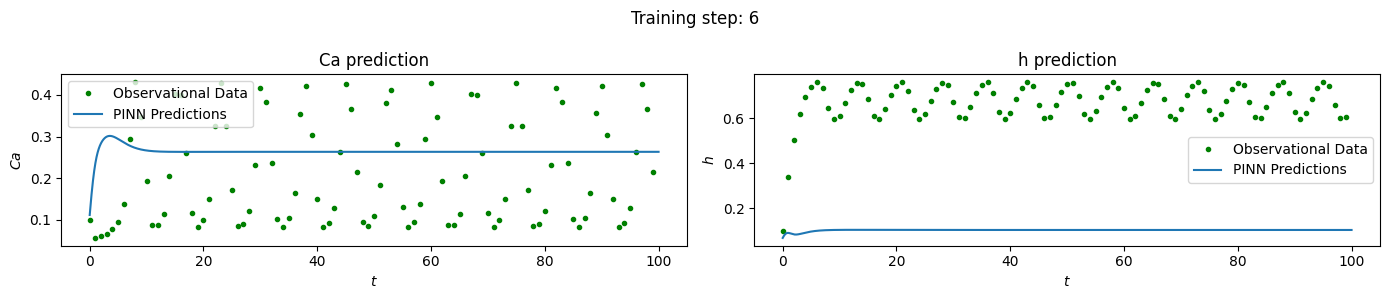

Training step: 7
Loss = 0.008956569246947765 | Physics_loss = 0.42393970489501953| Initial_loss = 0.0012107319198548794 | Data_loss = 0.3506440222263336


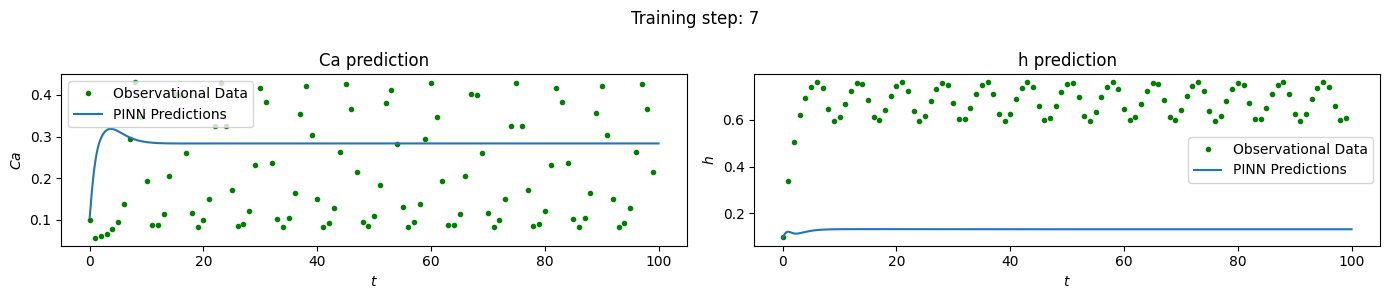

Training step: 8
Loss = 0.0070892274379730225 | Physics_loss = 0.38235488533973694| Initial_loss = 6.0811413277406245e-05 | Data_loss = 0.32048675417900085


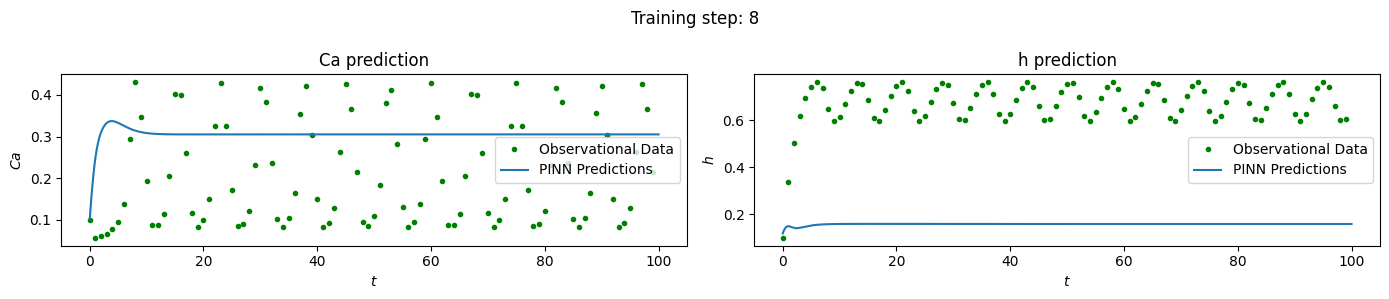

Training step: 9
Loss = 0.006752023473381996 | Physics_loss = 0.3438291549682617| Initial_loss = 0.000363085709977895 | Data_loss = 0.29506462812423706


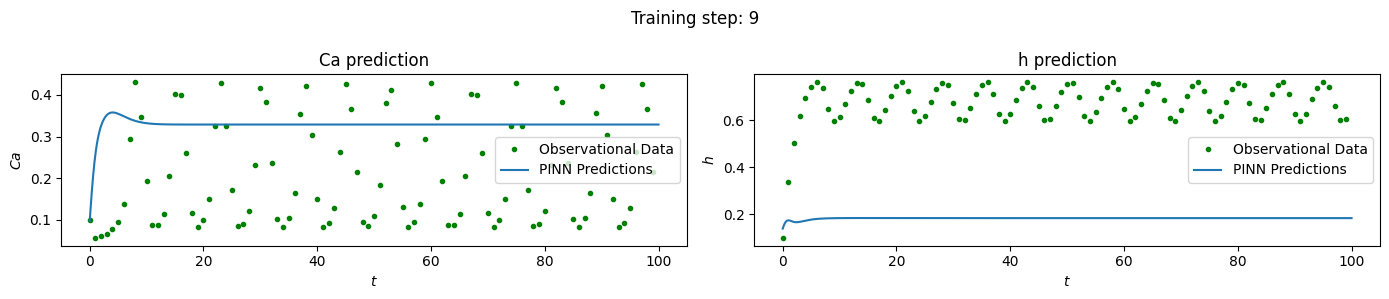

Training step: 10
Loss = 0.007404442876577377 | Physics_loss = 0.30785632133483887| Initial_loss = 0.001578435767441988 | Data_loss = 0.2747443914413452


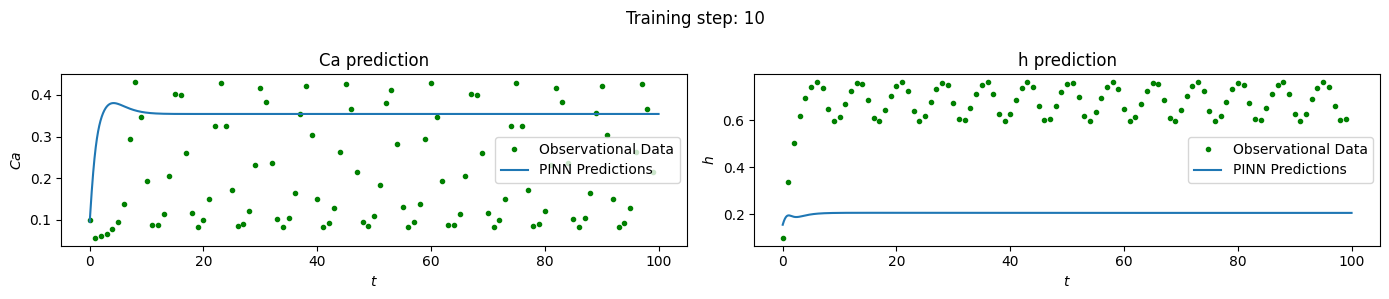

Training step: 11
Loss = 0.00850720889866352 | Physics_loss = 0.2744190990924835| Initial_loss = 0.003164958208799362 | Data_loss = 0.25980594754219055


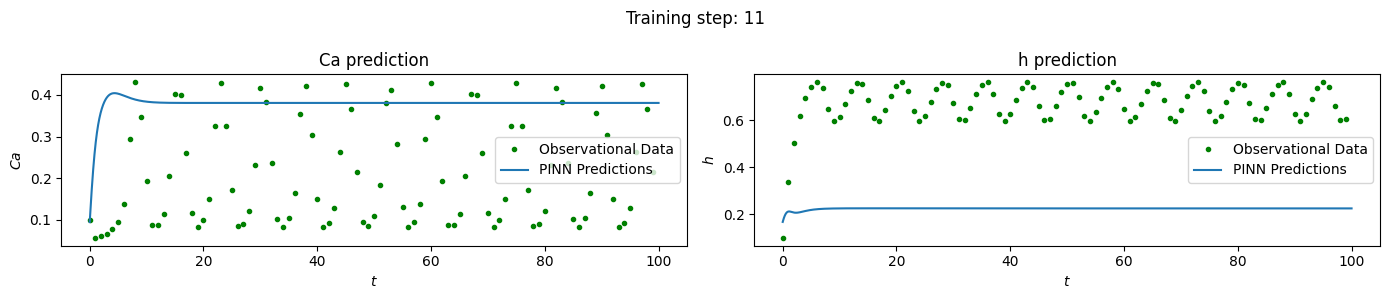

Training step: 12
Loss = 0.009600923396646976 | Physics_loss = 0.24370600283145905| Initial_loss = 0.004660962149500847 | Data_loss = 0.2502900958061218


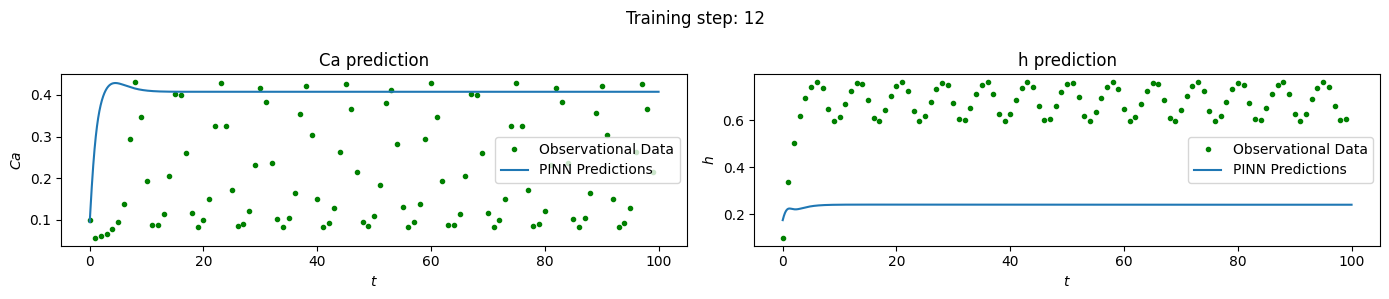

Training step: 13
Loss = 0.010366834700107574 | Physics_loss = 0.21580667793750763| Initial_loss = 0.00574962142854929 | Data_loss = 0.24591463804244995


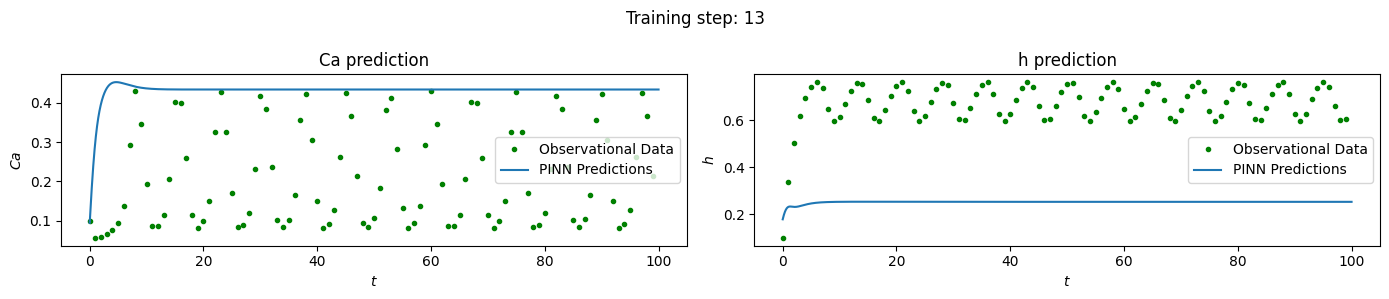

Training step: 14
Loss = 0.010646805167198181 | Physics_loss = 0.19060592353343964| Initial_loss = 0.006279538385570049 | Data_loss = 0.24612084031105042


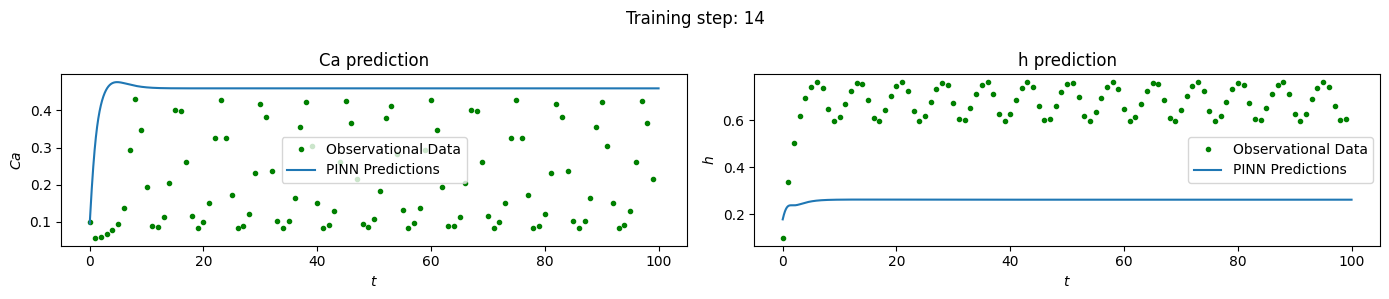

Training step: 15
Loss = 0.010423962958157063 | Physics_loss = 0.1678951382637024| Initial_loss = 0.00624303100630641 | Data_loss = 0.2501980662345886


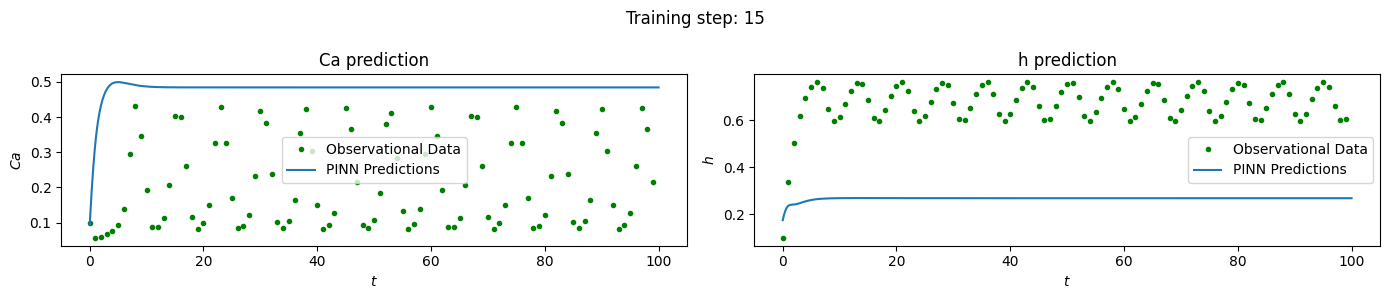

Training step: 16
Loss = 0.009780769236385822 | Physics_loss = 0.14748510718345642| Initial_loss = 0.005731987301260233 | Data_loss = 0.2573930621147156


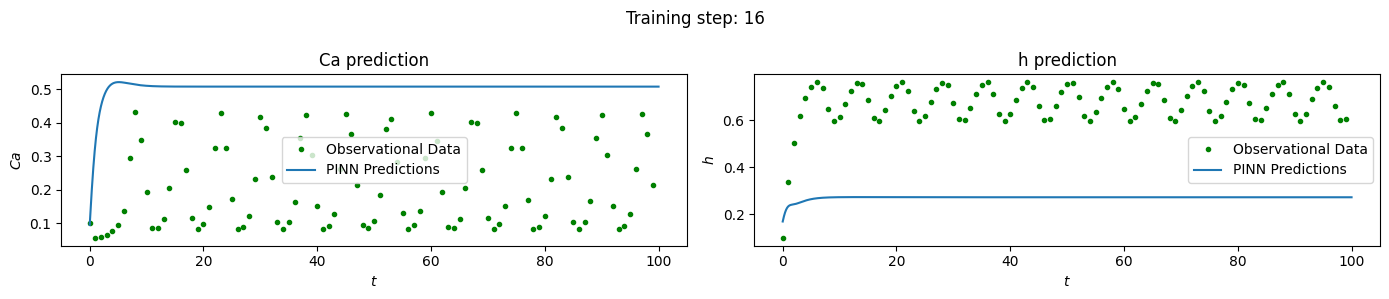

Training step: 17
Loss = 0.008853448554873466 | Physics_loss = 0.1292324662208557| Initial_loss = 0.004891330376267433 | Data_loss = 0.26697930693626404


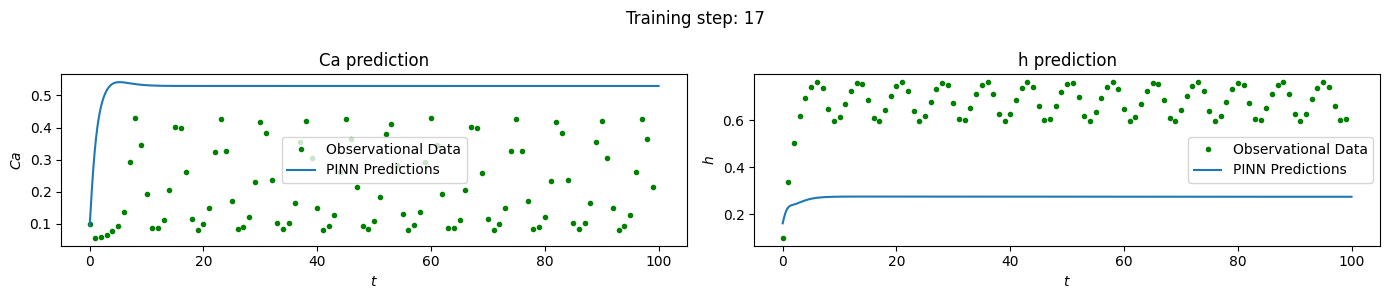

Training step: 18
Loss = 0.007793596480041742 | Physics_loss = 0.11301986873149872| Initial_loss = 0.003880478907376528 | Data_loss = 0.27829188108444214


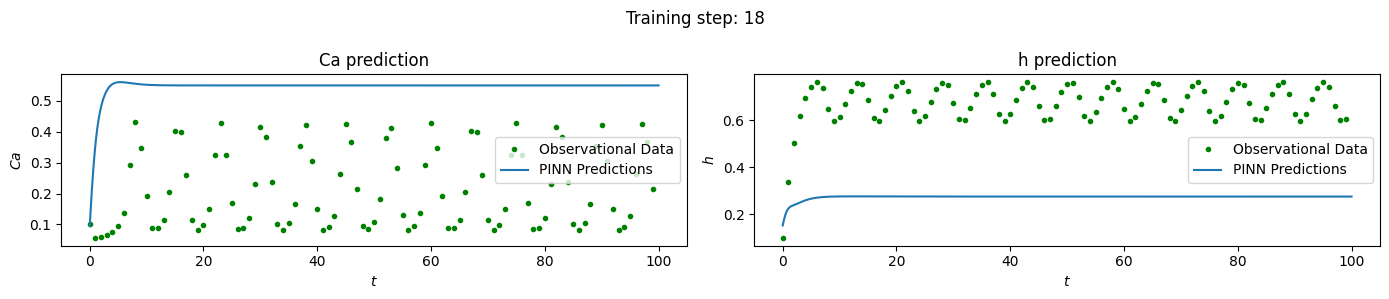

Training step: 19
Loss = 0.00674021802842617 | Physics_loss = 0.09873251616954803| Initial_loss = 0.0028455089777708054 | Data_loss = 0.29073840379714966


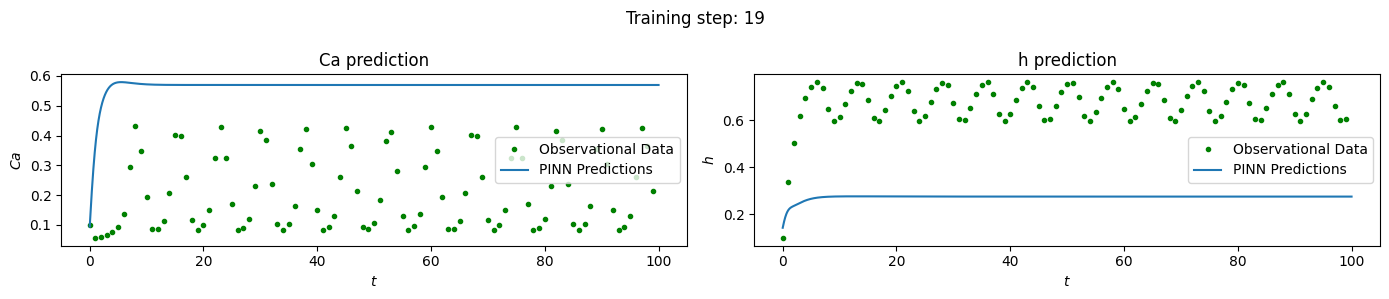

Training step: 20
Loss = 0.005802242550998926 | Physics_loss = 0.08624564111232758| Initial_loss = 0.0019018531311303377 | Data_loss = 0.3037933111190796


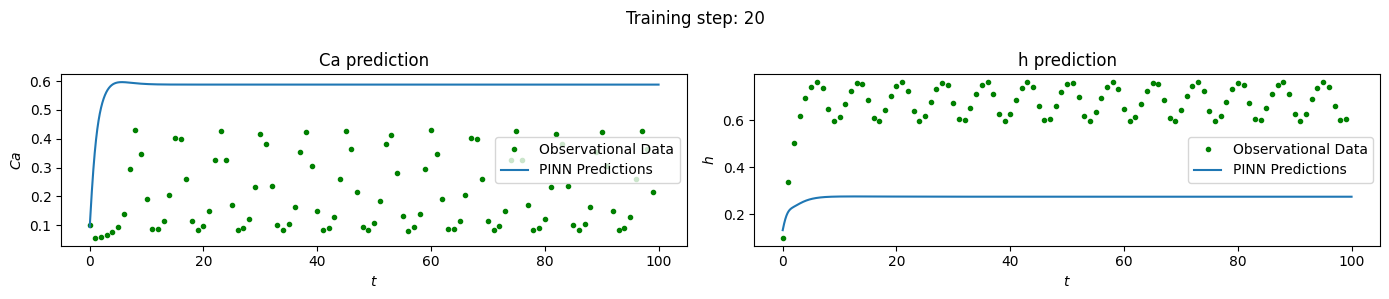

In [10]:
torch.manual_seed(42)
pinn = PinnModel(hidden_units=30)

Ca_euler = torch.tensor(Ca_euler1, dtype=torch.float32)[::100]
h_euler = torch.tensor(h_euler1, dtype=torch.float32)[::100]
t_test = torch.arange(0, 100, 0.01).view(-1, 1)
time = torch.arange(0, 100, 1.0).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, 100, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.10
k3  = 0.08
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.1
#a2 = 0.15

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  20
v2s = []
a2s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - 0.1)**2
    loss4 = (torch.squeeze(h0) - 0.1)**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 1 == 0:
        print(f"Training step: {i+1}")
        print(f"Loss = {loss} | Physics_loss = {loss5 + loss6}| Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 3))
        plt.suptitle(f"Training step: {i+1}")

        plt.subplot(121)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(122)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()
        plt.tight_layout()
        plt.show()


# **With Fourier Features**

In [13]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        mean = 0.0
        std = 2.0
        size = (num_features, 1)
        self.sine_coeff = torch.normal(mean, std, size=size)   
        self.cosine_coeff = torch.normal(mean, std, size=size)

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features):
        super().__init__()
        self.feature = FourierFeatureLayer(num_features=num_features)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        return out

Training step: 1
Loss = 0.021098464727401733 | Physics_loss = 1.3300530910491943| Initial_loss = 0.003960903268307447 | Data_loss = 0.3837030827999115


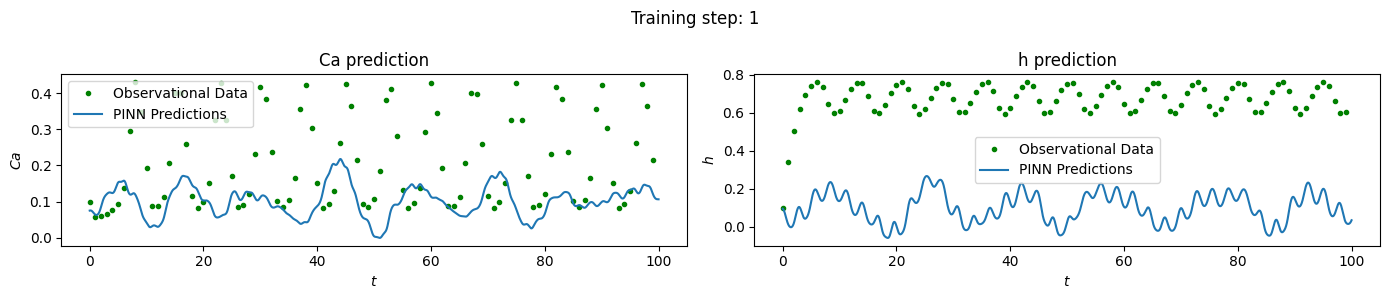

Training step: 2
Loss = 0.01555219292640686 | Physics_loss = 1.1187410354614258| Initial_loss = 0.0006693723844364285 | Data_loss = 0.36954110860824585


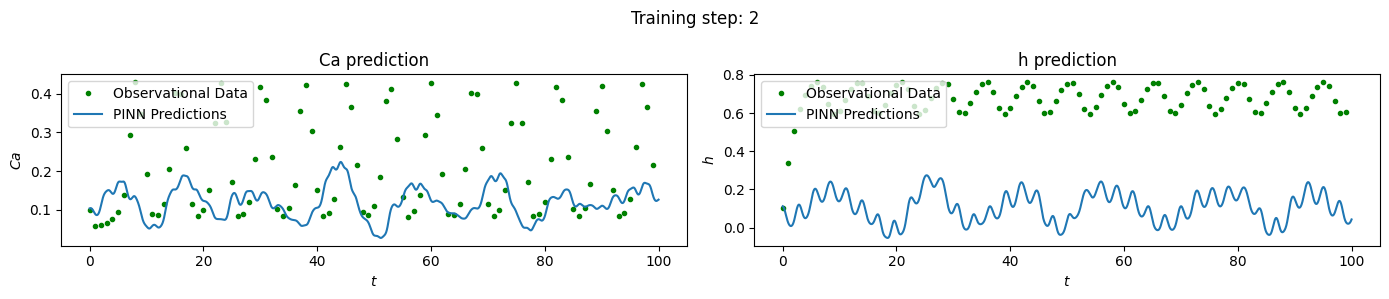

Training step: 3
Loss = 0.013029427267611027 | Physics_loss = 0.9325857162475586| Initial_loss = 0.00013634745846502483 | Data_loss = 0.35672223567962646


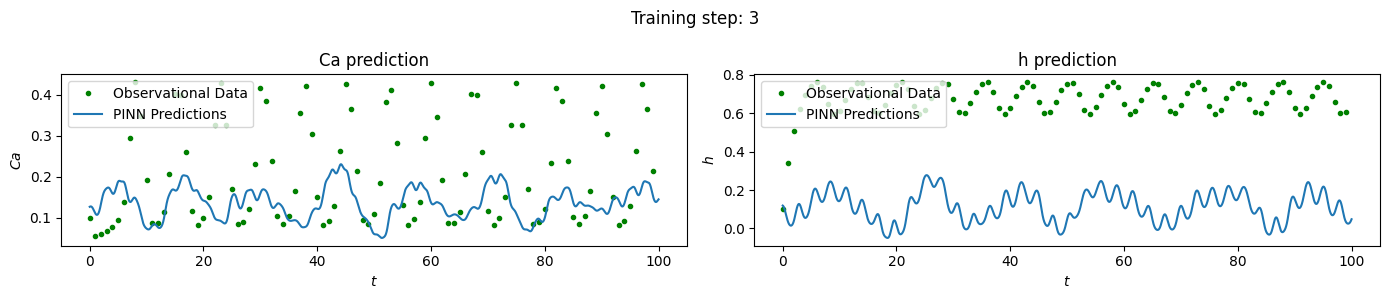

Training step: 4
Loss = 0.012443953193724155 | Physics_loss = 0.7899191975593567| Initial_loss = 0.0010722228325903416 | Data_loss = 0.34725382924079895


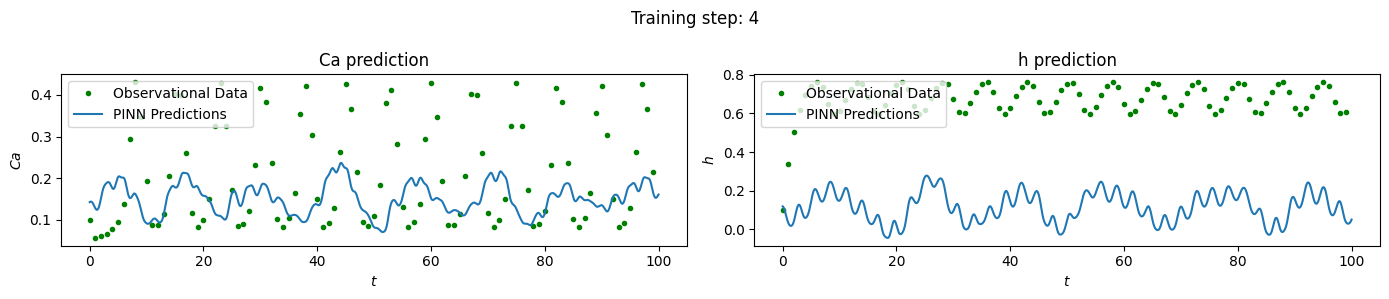

Training step: 5
Loss = 0.012493949383497238 | Physics_loss = 0.6926380395889282| Initial_loss = 0.002148278523236513 | Data_loss = 0.3419291079044342


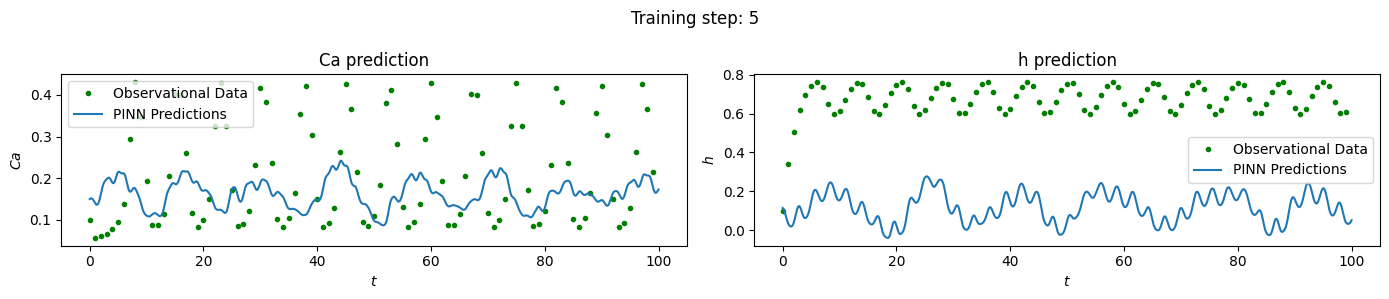

Training step: 6
Loss = 0.012361199595034122 | Physics_loss = 0.6298490166664124| Initial_loss = 0.0026688366197049618 | Data_loss = 0.33938732743263245


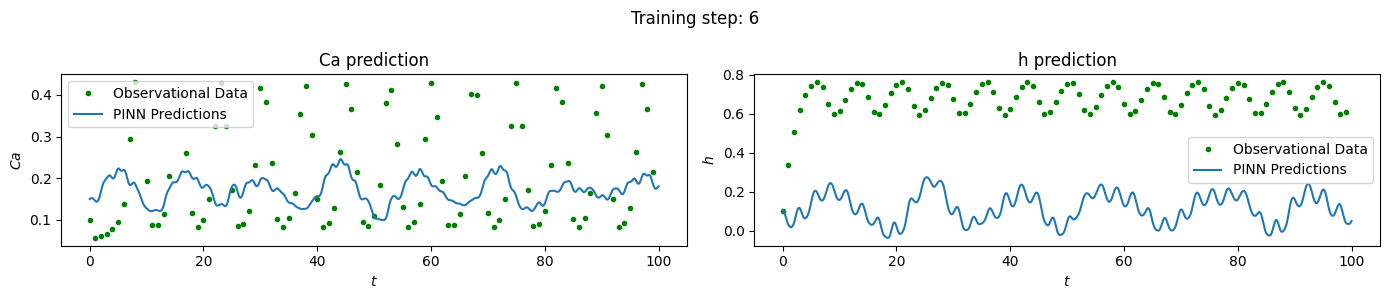

Training step: 7
Loss = 0.011806480586528778 | Physics_loss = 0.5902926325798035| Initial_loss = 0.0025242238771170378 | Data_loss = 0.3379330635070801


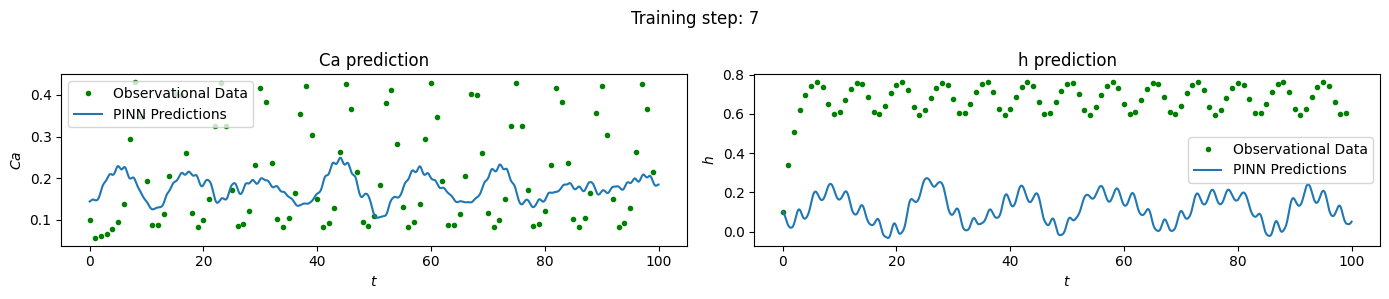

Training step: 8
Loss = 0.010952929966151714 | Physics_loss = 0.5657000541687012| Initial_loss = 0.0019322038860991597 | Data_loss = 0.33637258410453796


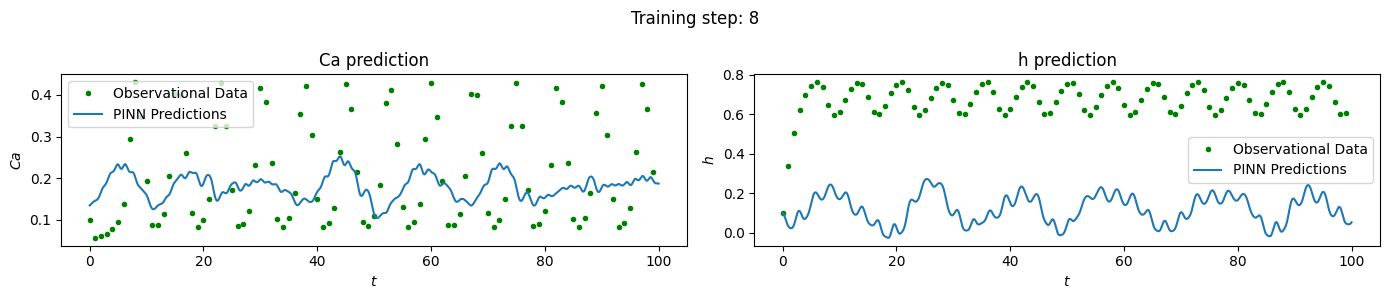

Training step: 9
Loss = 0.010032450780272484 | Physics_loss = 0.5506641268730164| Initial_loss = 0.0011856491910293698 | Data_loss = 0.3340160548686981


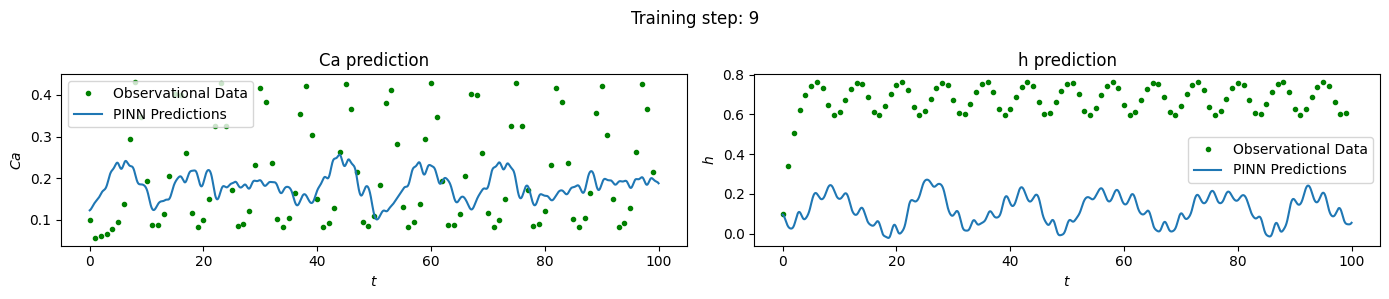

Training step: 10
Loss = 0.009251177310943604 | Physics_loss = 0.54161137342453| Initial_loss = 0.0005291664856486022 | Data_loss = 0.33058977127075195


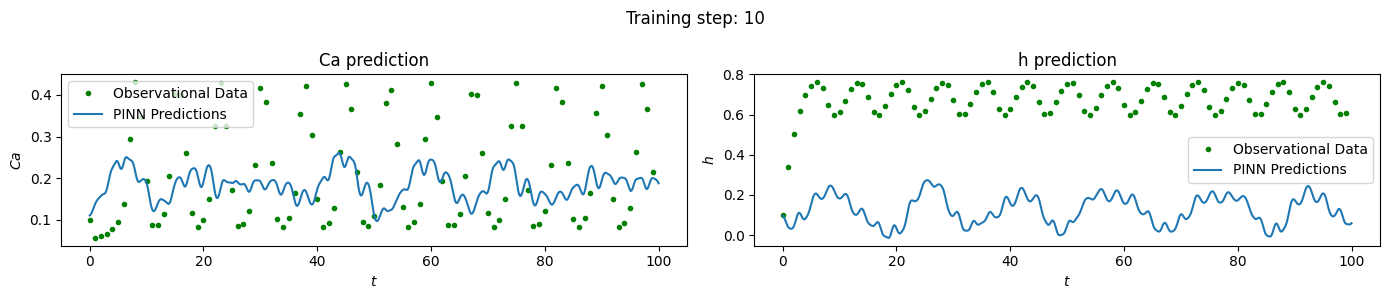

Training step: 11
Loss = 0.008739432319998741 | Physics_loss = 0.5358589887619019| Initial_loss = 0.00011955292575294152 | Data_loss = 0.32612892985343933


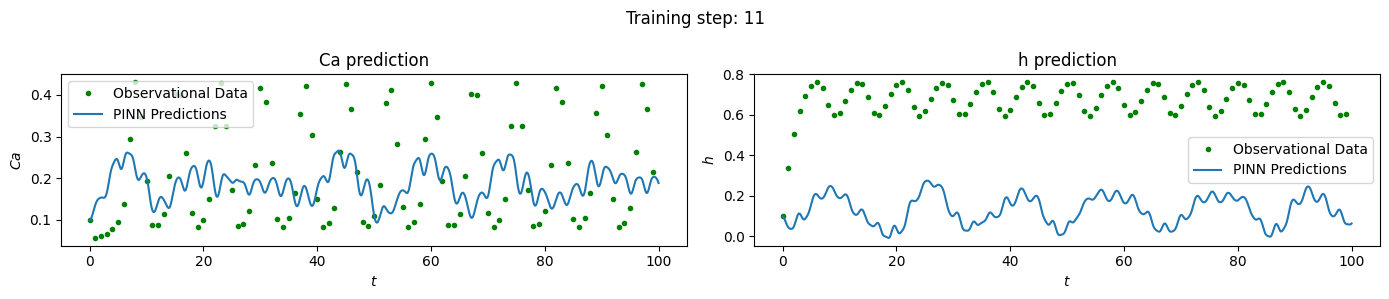

Training step: 12
Loss = 0.008522946387529373 | Physics_loss = 0.5309646129608154| Initial_loss = 4.67638710688334e-06 | Data_loss = 0.32086238265037537


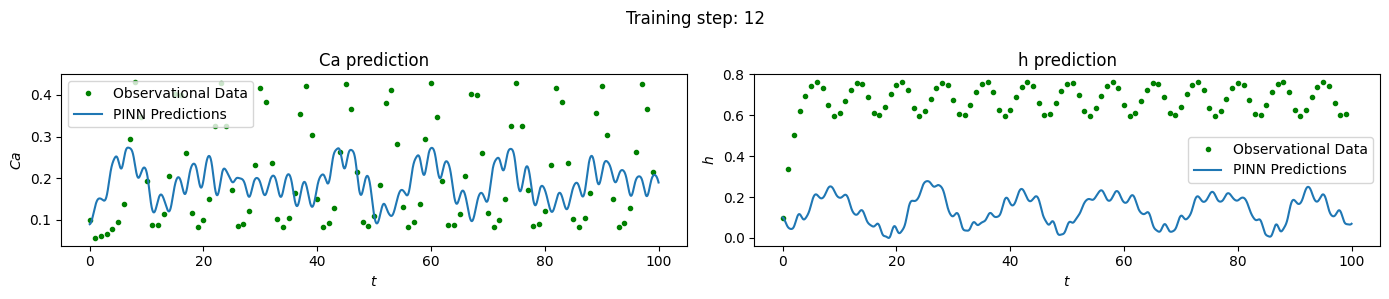

Training step: 13
Loss = 0.00851017888635397 | Physics_loss = 0.5244905948638916| Initial_loss = 0.00011408511636545882 | Data_loss = 0.3151187598705292


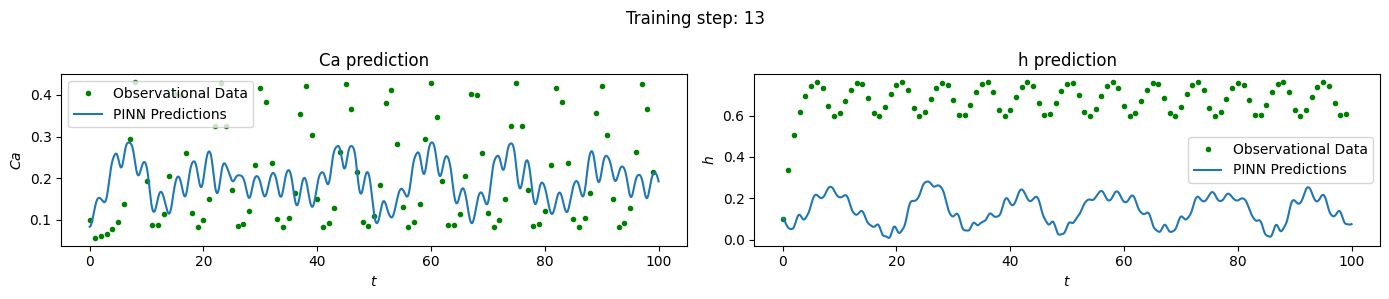

Training step: 14
Loss = 0.008529148995876312 | Physics_loss = 0.5143803954124451| Initial_loss = 0.00029303168412297964 | Data_loss = 0.30923134088516235


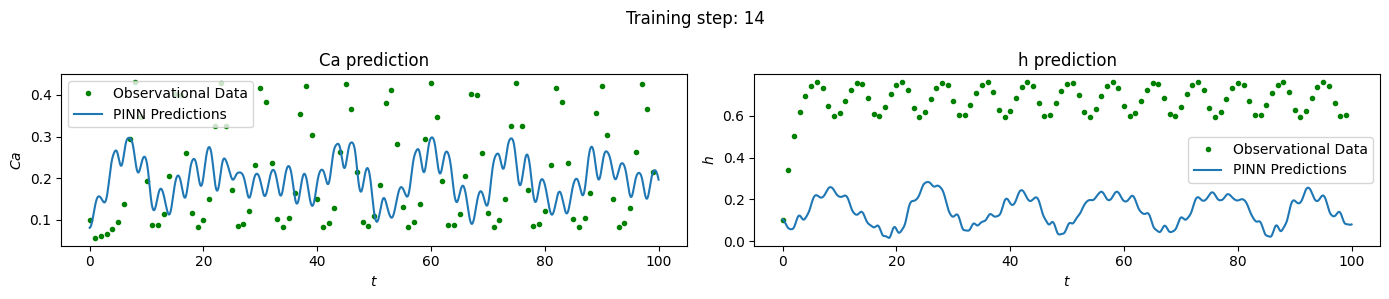

Training step: 15
Loss = 0.00842464342713356 | Physics_loss = 0.49971210956573486| Initial_loss = 0.00039300983189605176 | Data_loss = 0.3034512996673584


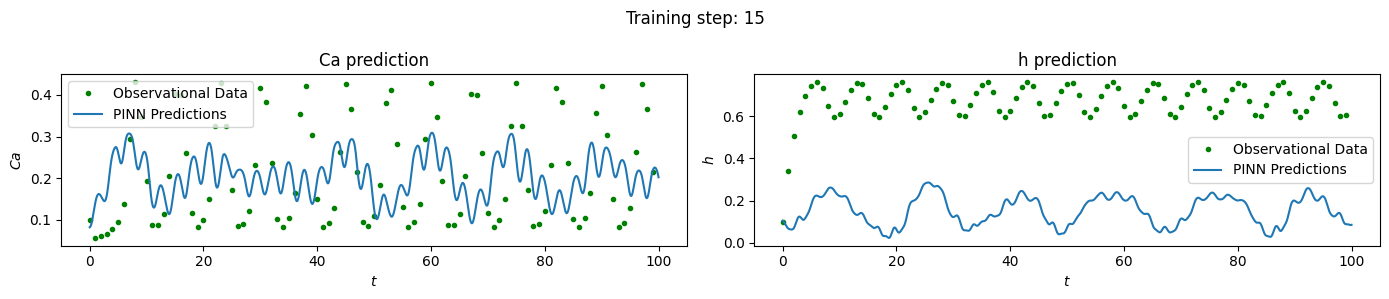

Training step: 16
Loss = 0.008144006133079529 | Physics_loss = 0.48099154233932495| Initial_loss = 0.0003549841931089759 | Data_loss = 0.2979107201099396


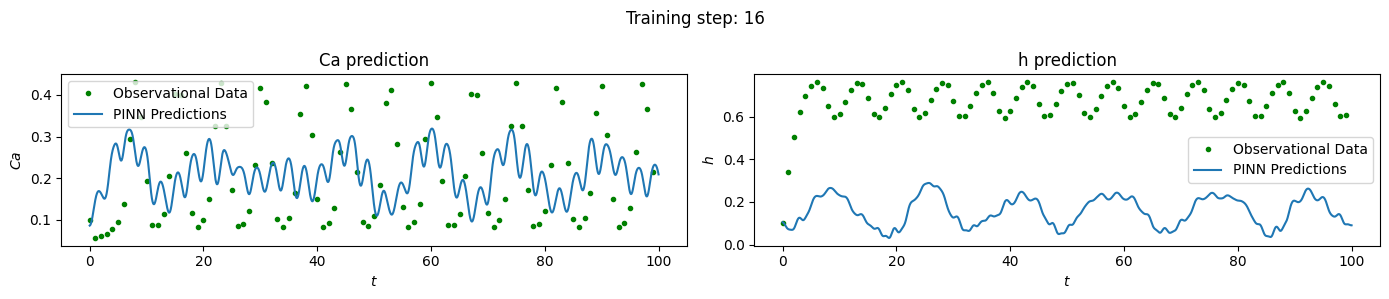

Training step: 17
Loss = 0.0077417753636837006 | Physics_loss = 0.4596797525882721| Initial_loss = 0.00021860102424398065 | Data_loss = 0.29263773560523987


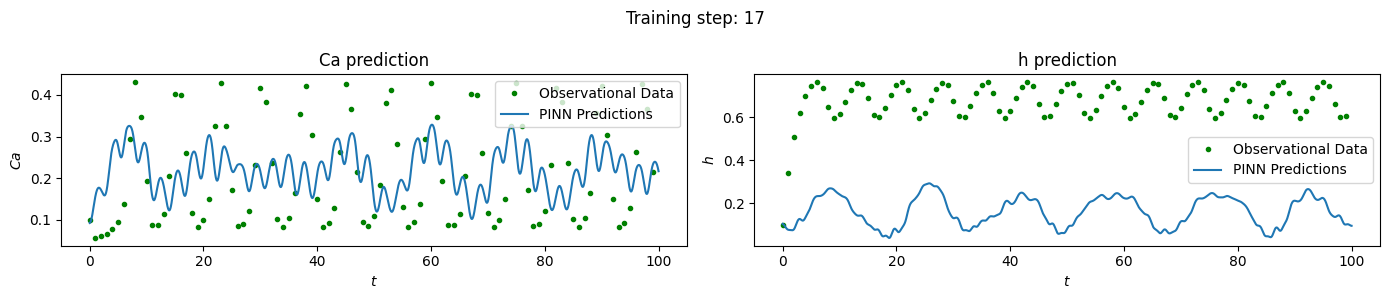

Training step: 18
Loss = 0.0073254285380244255 | Physics_loss = 0.43748921155929565| Initial_loss = 7.466260285582393e-05 | Data_loss = 0.28758740425109863


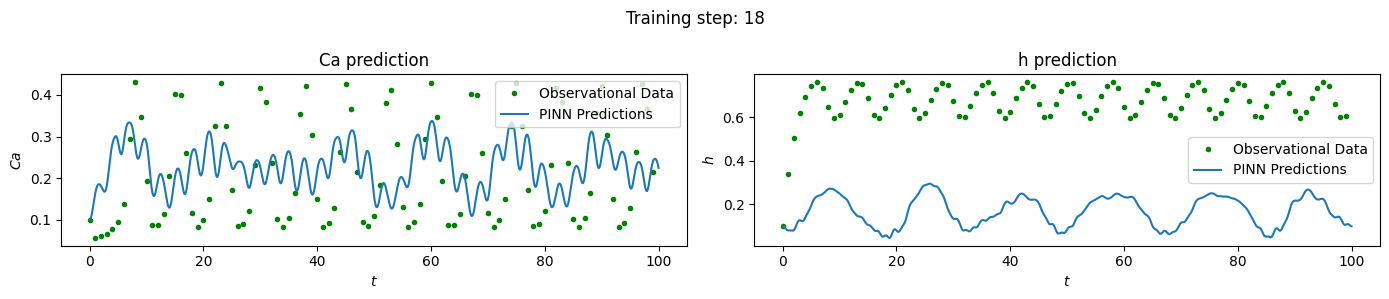

Training step: 19
Loss = 0.0069936709478497505 | Physics_loss = 0.41591012477874756| Initial_loss = 7.869670298532583e-06 | Data_loss = 0.2826700210571289


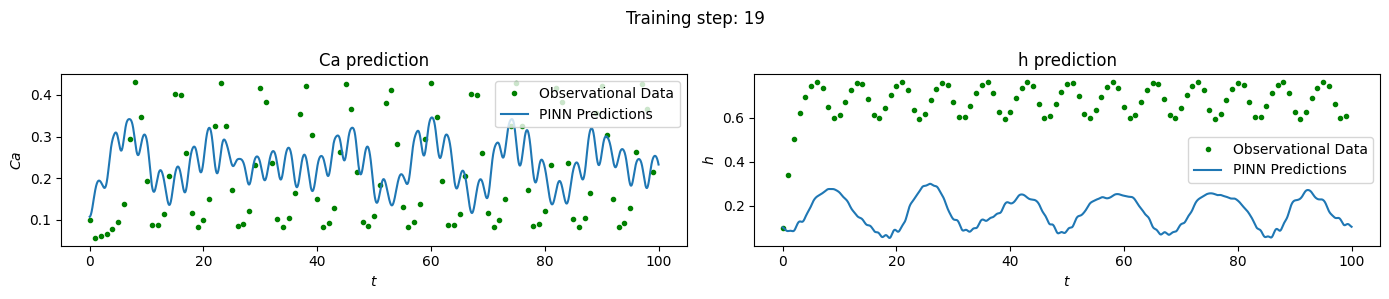

Training step: 20
Loss = 0.00679380539804697 | Physics_loss = 0.39603671431541443| Initial_loss = 5.5666419939370826e-05 | Data_loss = 0.27777722477912903


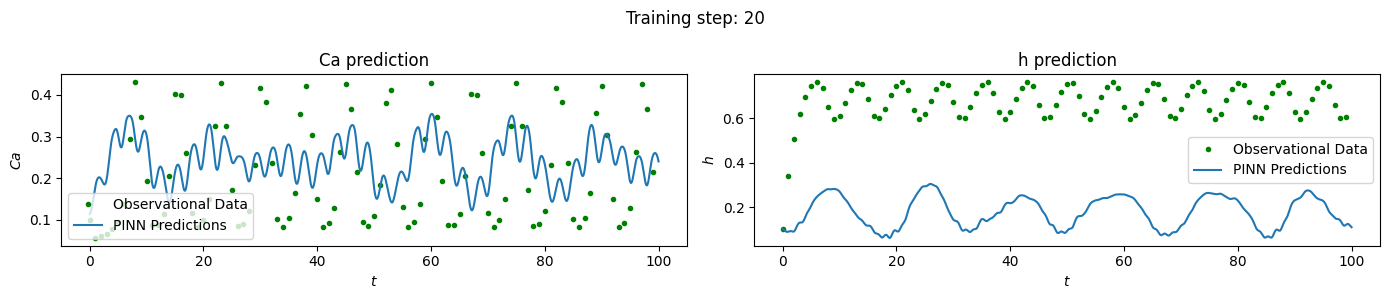

In [14]:
torch.manual_seed(42)
pinn = PinnModel(hidden_units=30, num_features=3)

Ca_euler = torch.tensor(Ca_euler1, dtype=torch.float32)[::100]
h_euler = torch.tensor(h_euler1, dtype=torch.float32)[::100]
t_test = torch.arange(0, 100, 0.01).view(-1, 1)
time = torch.arange(0, 100, 1.0).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, 100, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.10
k3  = 0.08
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.1
#a2 = 0.15

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  20
v2s = []
a2s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - 0.1)**2
    loss4 = (torch.squeeze(h0) - 0.1)**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 1 == 0:
        print(f"Training step: {i+1}")
        print(f"Loss = {loss} | Physics_loss = {loss5 + loss6}| Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 3))
        plt.suptitle(f"Training step: {i+1}")

        plt.subplot(121)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(122)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()
        plt.tight_layout()
        plt.show()
